# Lucas Henneaux : DATASET CREATION

Ce notebook permet de creer un dataset de patches avec un certain level de résolution comme expliqué dans le mémoire. C'est donc le premier block des 4 de la pipeline !

## Imports

In [1]:
import os
import sys

import numpy as np
import matplotlib.pyplot as plt
import torchvision.transforms as transforms
import math



import large_image

# !pip install openslide-python tifffile
import torch
from timm import create_model
from sklearn.cluster import DBSCAN
import timm
import random
import json



In [2]:
import torch

if torch.cuda.is_available():
    device = torch.device('cuda:0')
    props = torch.cuda.get_device_properties(device)
    print(f"Nom : {props.name}")
    print(f"Total memory : {props.total_memory / 1e9:.2f} GB")
    print(f"Multi processeurs count : {props.multi_processor_count}")
    
else:
    print("Pas de GPU disponible.")


Nom : NVIDIA GeForce GTX 1650
Total memory : 4.29 GB
Multi processeurs count : 14


In [ ]:
def save_dict(data, filename):
    """Save dict in json file"""
    with open(filename, 'w') as f:
        json.dump(data, f, indent=4)
    print(f"{filename} saved")

def load_dict(filename):
    """Load dict from json file"""
    with open(filename, 'r') as f:
        return json.load(f)

res=1 #Level de résolution ! 
label_path = f"labels{res}/"
classes = ["1","2","3","41","42","51","52","54","57"]


### Extraire les labels des WSI's

In [4]:
import xml.etree.ElementTree as ET
import openslide
import large_image
import cv2
def convert_ndpa_to_ndpi(x_ndpa, y_ndpa, slide):
    #Converts a point in .ndpa coords system to the .ndpi one
    
    # useful informations (I think only available with openSlide, but not sure)
    physical_width = float(slide.properties.get("hamamatsu.PhysicalWidth", 1))
    physical_height = float(slide.properties.get("hamamatsu.PhysicalHeight", 1))
    x_offset = float(slide.properties.get("hamamatsu.XOffsetFromSlideCentre", 0))
    y_offset = float(slide.properties.get("hamamatsu.YOffsetFromSlideCentre", 0))

    mpp_x = float(slide.properties["openslide.mpp-x"])
    mpp_y = float(slide.properties["openslide.mpp-y"])


    # Offsets
    x_offset_total = x_offset
    y_offset_total = y_offset

    
    # Conversion NDPA → NDPI
    x_ndpi = (x_ndpa - x_offset_total) / (mpp_x * 1000) + slide.dimensions[0]/2
    y_ndpi = (y_ndpa - y_offset_total) / (mpp_y * 1000)  + slide.dimensions[1]/2
    
    return int(x_ndpi), int(y_ndpi)

import xml.etree.ElementTree as ET
import random

def extract_annotations(ndpa_path, slide, low_res, scale_factor):
    import xml.etree.ElementTree as ET
    import random

    tree = ET.parse(ndpa_path)
    root = tree.getroot()

    annotations = []
    titles = []

    rects_51 = []
    rects_52 = []

    min_size = 224 * scale_factor
    tolerance = min_size * 0.7

    def rectangles_overlap(r1, r2):
        x1_min, y1_min, x1_max, y1_max = r1
        x2_min, y2_min, x2_max, y2_max = r2
        return not (x1_max <= x2_min or x2_max <= x1_min or y1_max <= y2_min or y2_max <= y1_min)

    for ndpviewstate in root.findall("ndpviewstate"): 
        annotation = ndpviewstate.find("annotation")
        specialtype = annotation.find("specialtype")
        title = ndpviewstate.find("title").text

        if specialtype is not None and "rectangle" in specialtype.text.lower():
            points = []
            for point in annotation.findall(".//point"):
                x = float(point.find("x").text)
                y = float(point.find("y").text)
                px, py = convert_ndpa_to_ndpi(x, y, slide)
                points.append((px, py))

            if len(points) == 4:
                x1, y1 = min(p[0] for p in points), min(p[1] for p in points)
                x2, y2 = max(p[0] for p in points), max(p[1] for p in points)

                width = x2 - x1
                height = y2 - y1

                if low_res:
                    if width < min_size and height < min_size and title not in ["51", "52"]:
                        continue

                if width < min_size:
                    extra_width = min_size - width
                    shift_x = random.uniform(0, extra_width)
                    x1 -= shift_x
                    x2 = x1 + min_size
                    width = min_size

                if height < min_size:
                    extra_height = min_size - height
                    shift_y = random.uniform(0, extra_height)
                    y1 -= shift_y
                    y2 = y1 + min_size
                    height = min_size

                width_mod = round(width % min_size)
                height_mod = round(height % min_size)

                if width_mod > 0:
                    correction = (min_size - width_mod) if width_mod > tolerance else width_mod
                    shift_left = random.uniform(0, correction)
                    shift_right = correction - shift_left
                    if width_mod > tolerance:
                        x1 -= shift_left
                        x2 += shift_right
                    else:
                        x1 += shift_left
                        x2 -= shift_right

                if height_mod > 0:
                    correction = (min_size - height_mod) if height_mod > tolerance else height_mod
                    shift_top = random.uniform(0, correction)
                    shift_bottom = correction - shift_top
                    if height_mod > tolerance:
                        y1 -= shift_top
                        y2 += shift_bottom
                    else:
                        y1 += shift_top
                        y2 -= shift_bottom

                rect = (x1, y1, x2, y2)

                if title in ["51", "52"]:
                    overlap_found = False
                    if title == "51":
                        # Check with existing 51
                        for r in rects_51:
                            if rectangles_overlap(rect, r):
                                print("Chevauchement entre deux annotations '51'. L'une est ignorée.")
                                overlap_found = True
                                break
                        # Check with existing 52 → supprimer 51 si chevauchement
                        if not overlap_found:
                            for r in rects_52:
                                if rectangles_overlap(rect, r):
                                    print("Chevauchement entre '51' et '52'. '51' est ignorée au profit de '52'.")
                                    overlap_found = True
                                    break
                        if not overlap_found:
                            rects_51.append(rect)
                            annotations.append(rect)
                            titles.append("51")
                    elif title == "52":
                        # Check with existing 52
                        for r in rects_52:
                            if rectangles_overlap(rect, r):
                                print("Chevauchement entre deux annotations '52'. L'une est ignorée.")
                                overlap_found = True
                                break
                        # Check with existing 51 → on conserve 52 et on retire les 51 qui se chevauchent
                        if not overlap_found:
                            indices_to_remove = []
                            for i, r in enumerate(rects_51):
                                if rectangles_overlap(rect, r):
                                    print("Chevauchement entre '52' et '51'. '52' est conservée, '51' est supprimée.")
                                    indices_to_remove.append(i)

                            for i in reversed(indices_to_remove):
                                del rects_51[i]
                                # supprimer aussi des annotations et titles associés
                                idxs = [j for j, (a, t) in enumerate(zip(annotations, titles)) if t == "51"]
                                if i < len(idxs):
                                    del annotations[idxs[i]]
                                    del titles[idxs[i]]

                            rects_52.append(rect)
                            annotations.append(rect)
                            titles.append("52")
                else:
                    annotations.append(rect)
                    titles.append(title)

                if round(x2 - x1) % 224 != 0 or round(y2 - y1) % 224 != 0:
                    print("ATTENTION dimension non multiple de 224 :", round(x2 - x1) % 224, round(y2 - y1) % 224)

    return annotations, titles




def get_res_image(slide, res, x1, y1, x2, y2, scale_factor):
    """ Getting image in a certain res and adapting according to this res (scale factor) """
    # return slide.read_region((int(int(x1) * scale_factor), int(int(y1) * scale_factor)), res, (int(x2)-int(x1), int(y2)-int(y1))).convert("RGB")
   
    return slide.read_region((round(x1), round(y1)), res, (round((x2-x1)/scale_factor), round((y2-y1)/scale_factor))).convert("RGB")



def process_ndpi_with_large_image(file_path, file_ndpa, output_folder_name, nth_image,classes, res=7):
    
    slide = openslide.OpenSlide(file_path)

    scale_factor = (slide.level_dimensions[0][0]/ slide.level_dimensions[res][0])

    low_res = False
    if label_path != f"labels{res}/":
        low_res = True

    annotations, titles = extract_annotations(file_ndpa, slide, low_res, scale_factor)

    for i, (x1, y1, x2, y2) in enumerate(annotations):

        img_region = get_res_image(slide, res, x1, y1, x2, y2, scale_factor)
        size = img_region.size

        if size[0] % 224 != 0 or size[1] %224 != 0:
            print("ATTENTION", size[0] %224, size[1] %224)
        try:
            output_folder = os.path.join(output_folder_name, titles[i])
        except:
            print(f"-----No annotation for {file_path} ------- ")
            return []
        if titles[i] not in classes:
            # print(f"----invalid label found : {titles[i]}-----")
            continue
        
        output_path = os.path.join(output_folder, f"{titles[i]}_{i}_{nth_image}.png")
        
        os.makedirs(output_folder, exist_ok=True)  # Creating folder if does not exist
        
        img_np = np.array(img_region)  # Convert PIL to NumPy
        cv2.imwrite(output_path, cv2.cvtColor(img_np, cv2.COLOR_RGB2BGR))

        # print(f"Saved : {output_path}")
    print(f"{file_path.split('/')[-1]} : {nth_image}")
    return annotations


folder_path = "img/database"

# Folder of wi images and .ndpa files !
files = os.listdir(folder_path)

ndpi_files = [f for f in files if f.endswith(".ndpi")]
ndpa_files = [f for f in files if f.endswith(".ndpi.ndpa")]


for i, ndpi_file in enumerate(ndpi_files):
    ndpa_file = ndpi_file + ".ndpa" #Corresponding .ndpa file
    
    if ndpa_file in ndpa_files:

        ndpi_path = os.path.join(folder_path, ndpi_file)
        ndpa_path = os.path.join(folder_path, ndpa_file)
        print("processing : ", ndpa_file," ...")
        process_ndpi_with_large_image(ndpi_path, ndpa_path, label_path, i,classes, res=res)
    else:
        print(f"No .ndpa file found {ndpi_file}")

processing :  09C07888.ndpi.ndpa  ...
Chevauchement entre deux annotations '52'. L'une est ignorée.
Chevauchement entre deux annotations '52'. L'une est ignorée.
database\09C07888.ndpi : 0
processing :  10C05634.ndpi.ndpa  ...
Chevauchement entre deux annotations '51'. L'une est ignorée.
Chevauchement entre deux annotations '51'. L'une est ignorée.
Chevauchement entre deux annotations '51'. L'une est ignorée.
Chevauchement entre deux annotations '51'. L'une est ignorée.
Chevauchement entre deux annotations '51'. L'une est ignorée.
Chevauchement entre deux annotations '51'. L'une est ignorée.
Chevauchement entre deux annotations '51'. L'une est ignorée.
Chevauchement entre deux annotations '51'. L'une est ignorée.
Chevauchement entre deux annotations '51'. L'une est ignorée.
Chevauchement entre deux annotations '51'. L'une est ignorée.
Chevauchement entre deux annotations '51'. L'une est ignorée.
Chevauchement entre deux annotations '51'. L'une est ignorée.
Chevauchement entre deux anno

KeyboardInterrupt: 

### Calcul du nombre de patches par label

In [ ]:
import os
from collections import defaultdict
from PIL import Image
import matplotlib.pyplot as plt


patch_size = (224, 224)
min_patch_area_ratio = 0.6

patches_count = {}

min_patch_area = patch_size[0] * patch_size[1] * min_patch_area_ratio

for class_folder in os.listdir(label_path):
    class_folder_path = os.path.join(label_path, class_folder)
    if os.path.isdir(class_folder_path):
        for image_name in os.listdir(class_folder_path):
            if image_name.lower().endswith(('png', 'jpg', 'jpeg')):
                image_id = image_name.split('_')[2].split('.')[0]
                image_path = os.path.join(class_folder_path, image_name)
                
                image = Image.open(image_path)
                width, height = image.size
               
                num_patches_x = max(1, (width + patch_size[0] - 1) // patch_size[0])
                num_patches_y = max(1, (height + patch_size[1] - 1) // patch_size[1])
                
                total_patches = 0
                for x in range(num_patches_x):
                    for y in range(num_patches_y):
                        actual_width = min(patch_size[0], width - x * patch_size[0])
                        actual_height = min(patch_size[1], height - y * patch_size[1])
                        
                        if actual_width * actual_height >= min_patch_area:
                            total_patches += 1
                try:
                    patches_count[class_folder_path + "/" + image_name] += max(1, total_patches) 
                except:
                    patches_count[class_folder_path + "/" + image_name] = max(1, total_patches)



for image_name, patche_count in patches_count.items():
    print(f"Image {image_name} : {patche_count}")

save_dict(patches_count, "patches_count.json")


Image labels1/1/1_10_13.png : 192
Image labels1/1/1_110_26.png : 275
Image labels1/1/1_111_26.png : 153
Image labels1/1/1_11_17.png : 81
Image labels1/1/1_13_17.png : 595
Image labels1/1/1_157_11.png : 2
Image labels1/1/1_20_5.png : 8
Image labels1/1/1_21_17.png : 180
Image labels1/1/1_21_5.png : 45
Image labels1/1/1_22_0.png : 40
Image labels1/1/1_22_3.png : 48
Image labels1/1/1_25_17.png : 1760
Image labels1/1/1_25_4.png : 1088
Image labels1/1/1_26_4.png : 852
Image labels1/1/1_27_4.png : 1716
Image labels1/1/1_35_8.png : 663
Image labels1/1/1_42_6.png : 287
Image labels1/1/1_43_6.png : 704
Image labels1/1/1_50_3.png : 1
Image labels1/1/1_51_3.png : 1
Image labels1/1/1_52_3.png : 1
Image labels1/1/1_53_3.png : 2
Image labels1/1/1_54_3.png : 3
Image labels1/1/1_55_3.png : 1
Image labels1/1/1_56_12.png : 672
Image labels1/1/1_56_15.png : 192
Image labels1/1/1_58_3.png : 24
Image labels1/1/1_7_3.png : 4
Image labels1/1/1_81_12.png : 156
Image labels1/1/1_8_3.png : 60
Image labels1/2/2_0

-----Processing for 2 class ... ------
labels1/
Testing with 2 clusters
Testing with 3 clusters
Testing with 4 clusters
Testing with 5 clusters
AgglomerativeClustering
KMeans++
SpectralClustering


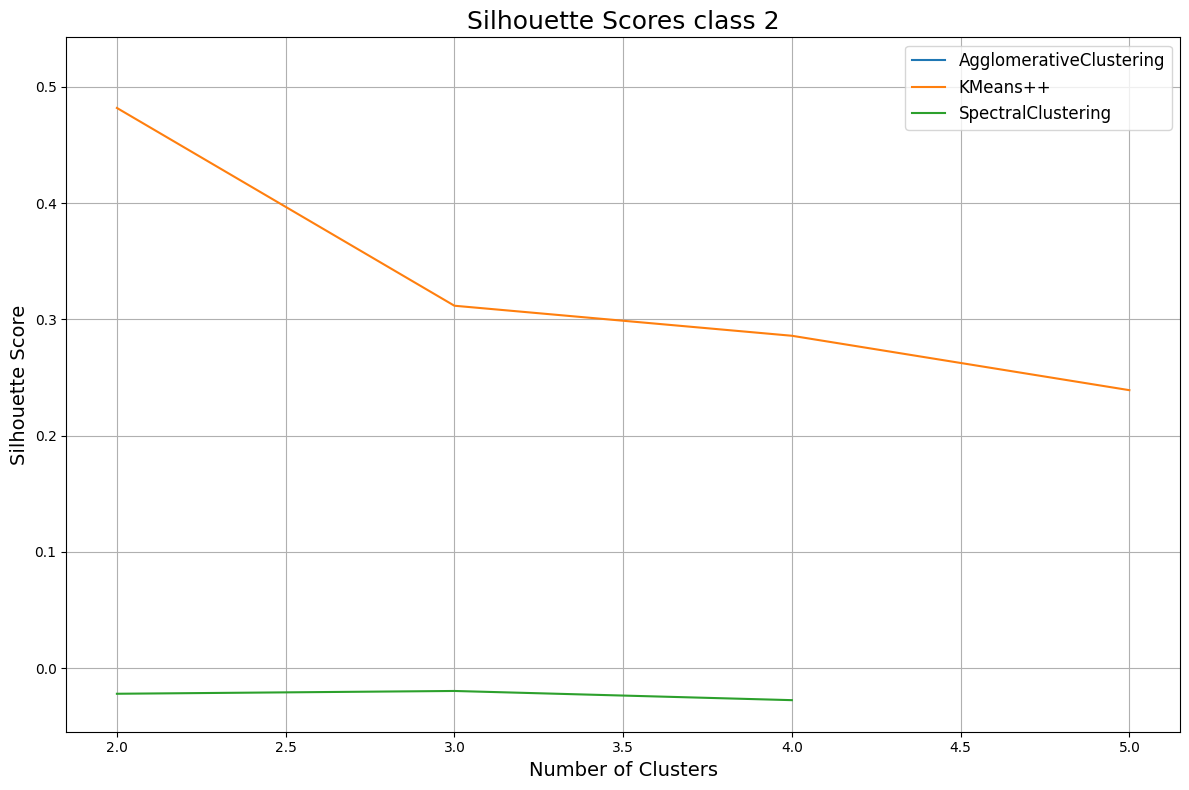

85 AgglomerativeClustering 2 1
85 AgglomerativeClustering 3 1
85 AgglomerativeClustering 4 1
40 AgglomerativeClustering 5 1
530 AgglomerativeClustering 2 2
69 AgglomerativeClustering 3 2
1 AgglomerativeClustering 4 2
1 AgglomerativeClustering 5 2
2 AgglomerativeClustering 2 3
2 AgglomerativeClustering 3 3
2 AgglomerativeClustering 4 3
2 AgglomerativeClustering 5 3
446 AgglomerativeClustering 2 41
176 AgglomerativeClustering 3 41
2 AgglomerativeClustering 4 41
2 AgglomerativeClustering 5 41
5 AgglomerativeClustering 2 42
5 AgglomerativeClustering 3 42
5 AgglomerativeClustering 4 42
2 AgglomerativeClustering 5 42
15 AgglomerativeClustering 2 51
1 AgglomerativeClustering 3 51
1 AgglomerativeClustering 4 51
1 AgglomerativeClustering 5 51
1 AgglomerativeClustering 2 52
1 AgglomerativeClustering 3 52
1 AgglomerativeClustering 4 52
1 AgglomerativeClustering 5 52
32 AgglomerativeClustering 2 54
12 AgglomerativeClustering 3 54
12 AgglomerativeClustering 4 54
11 AgglomerativeClustering 5 54
1 Ag

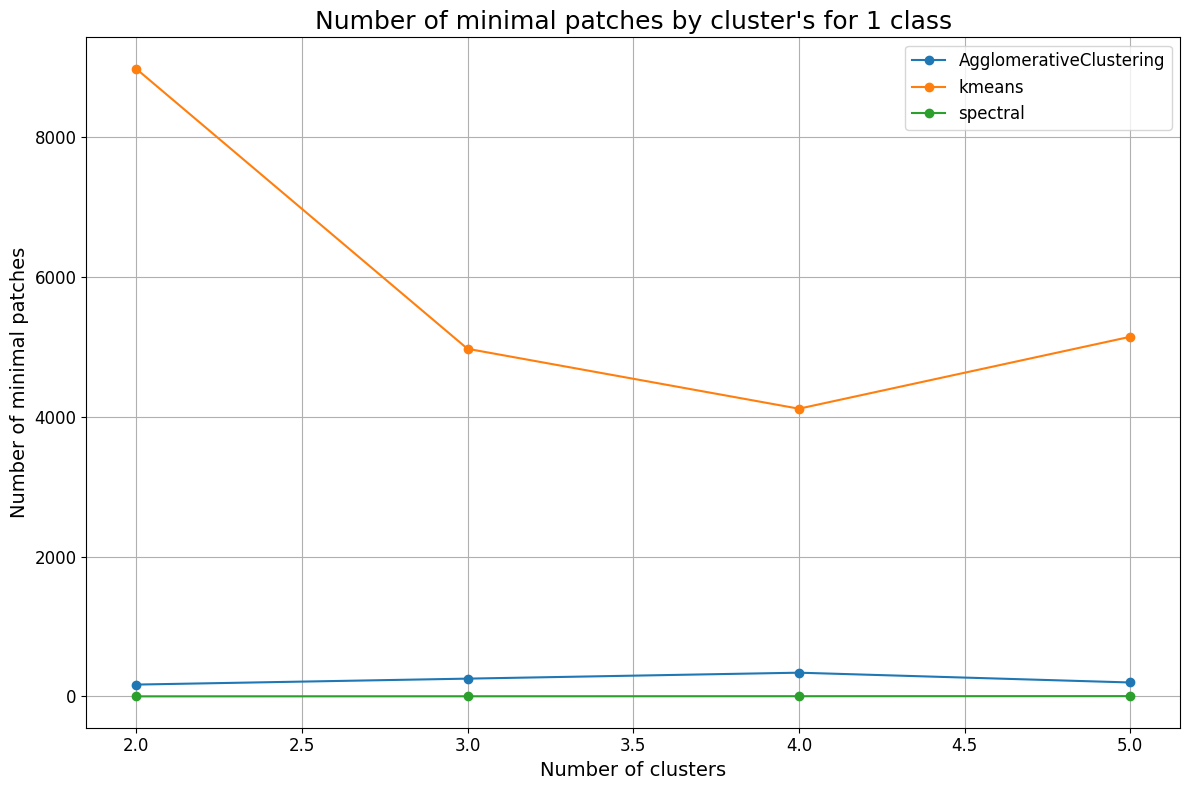

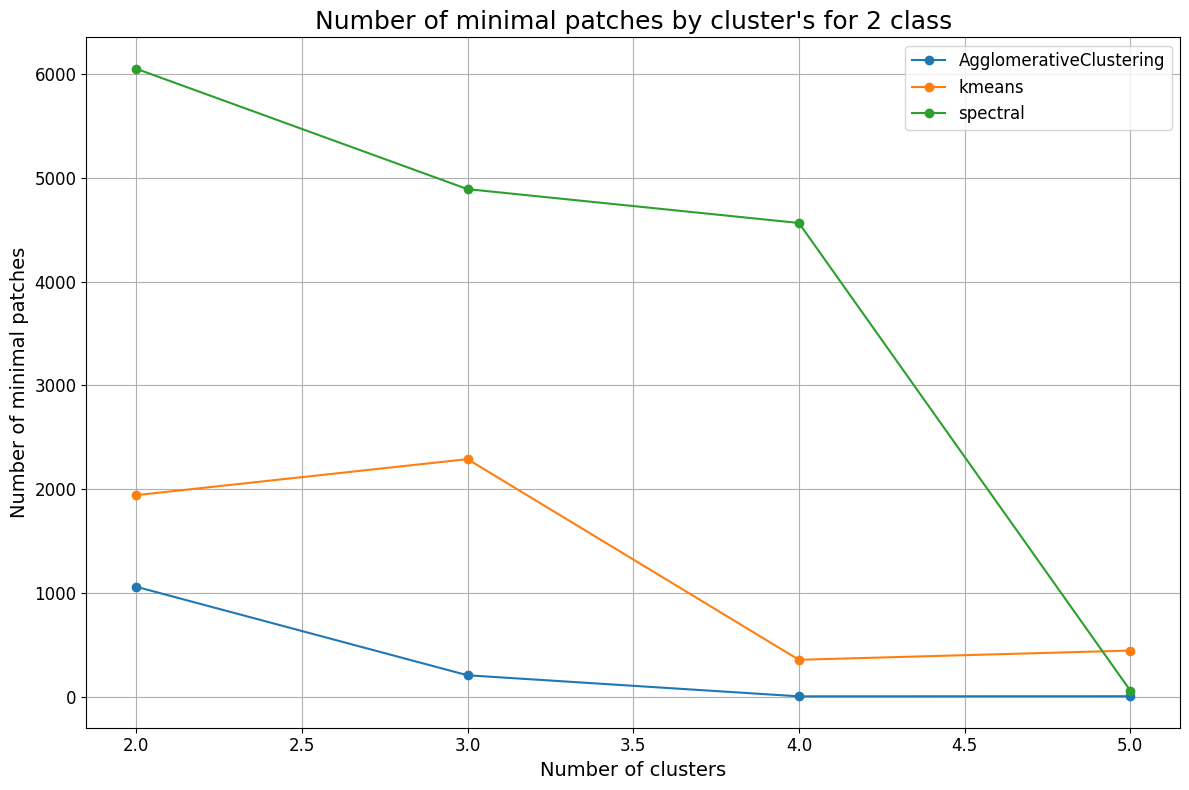

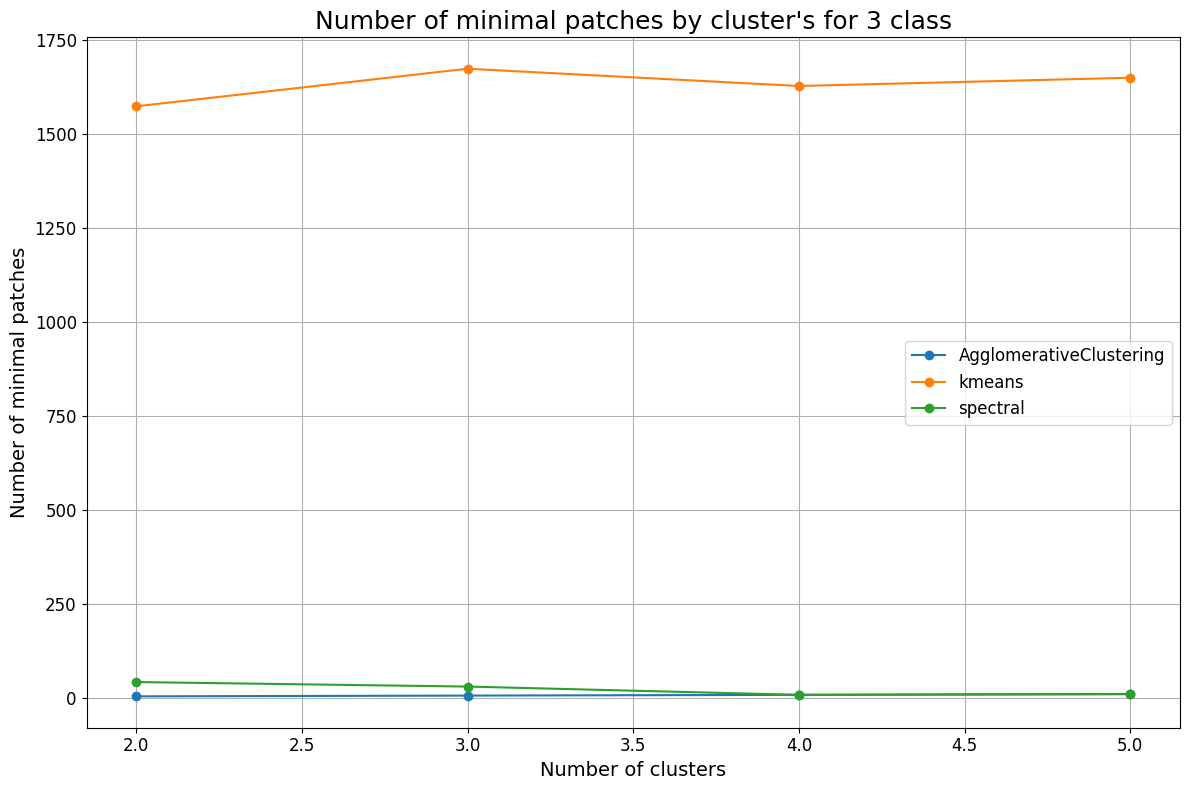

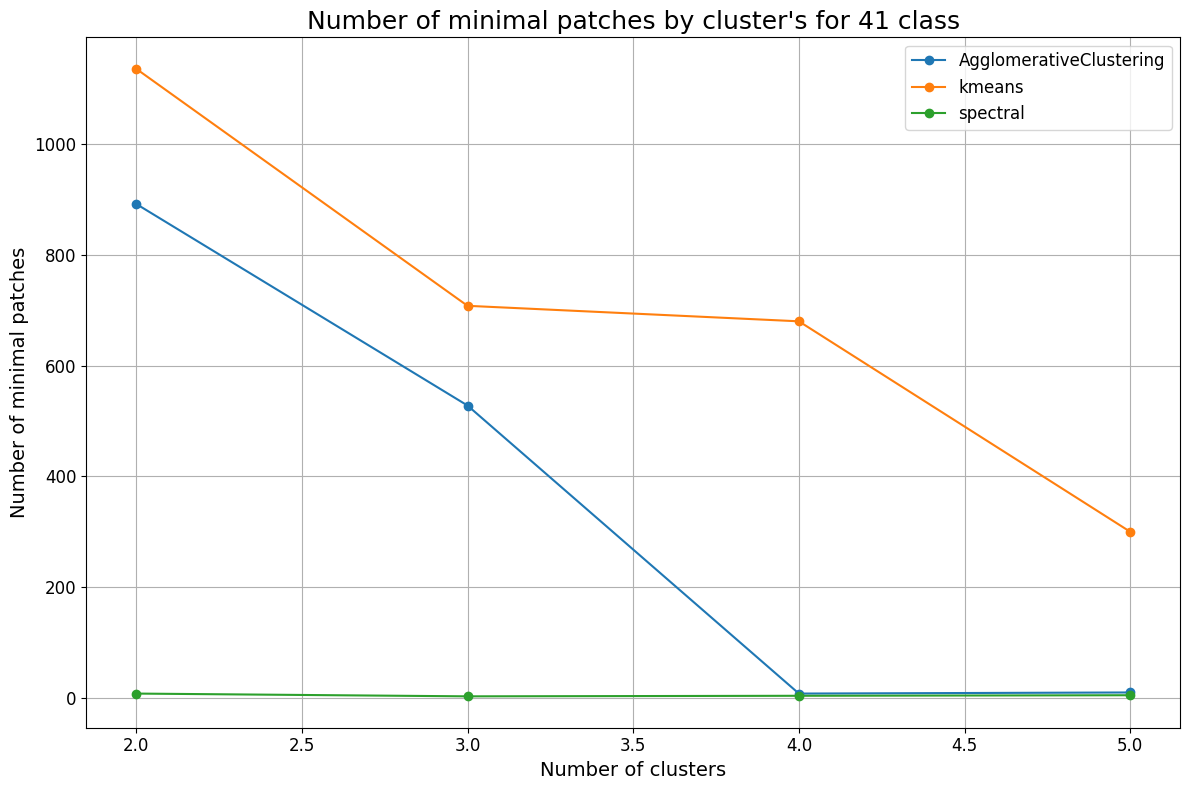

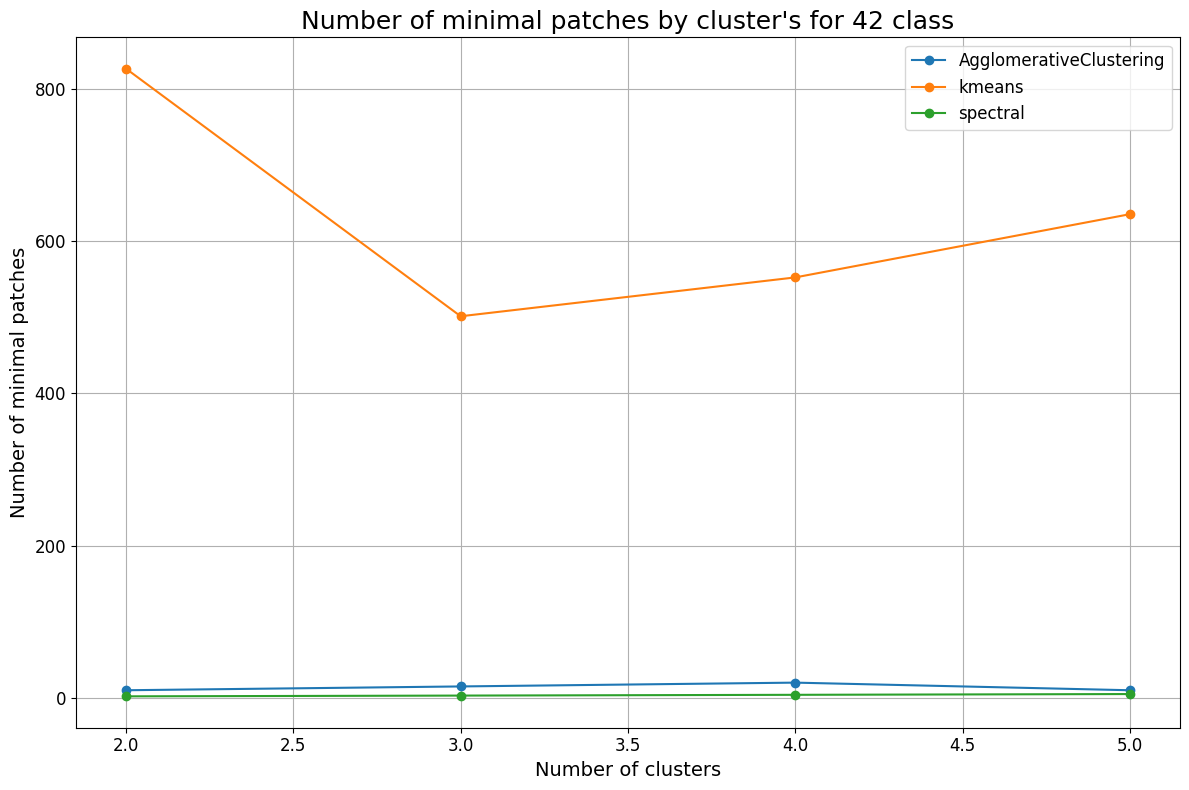

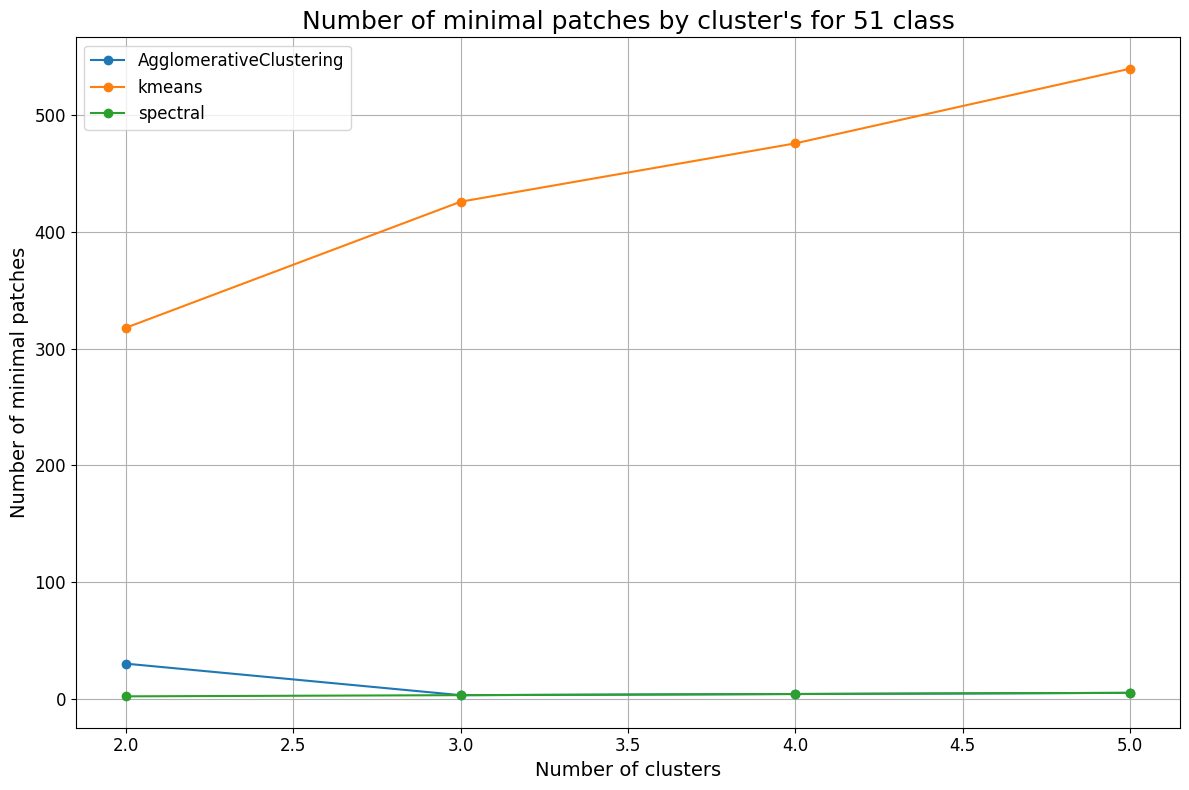

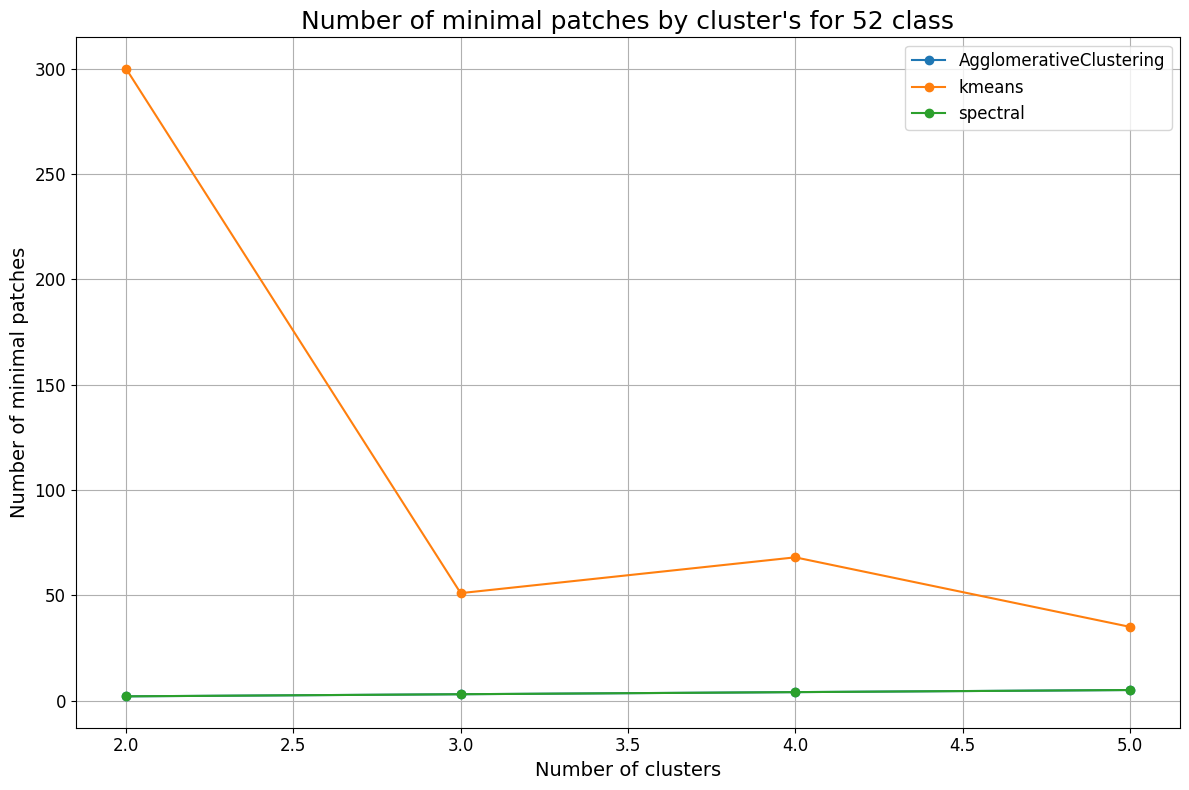

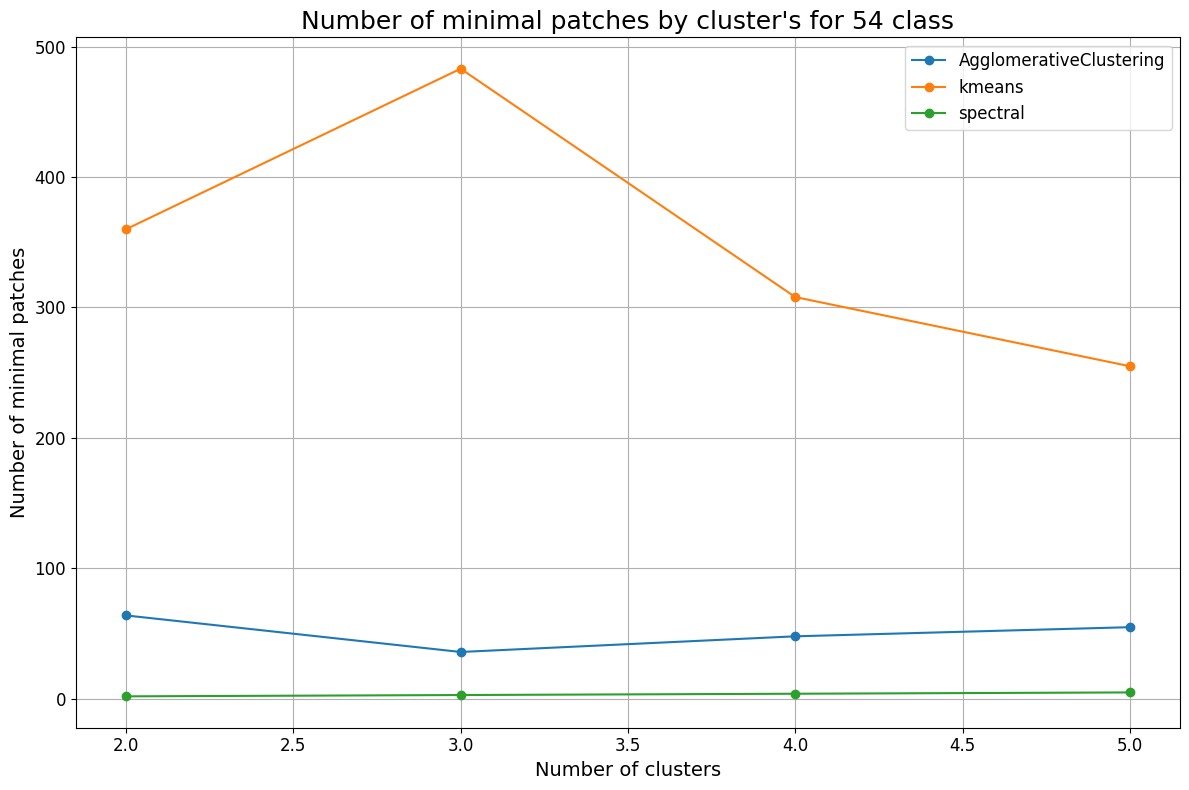

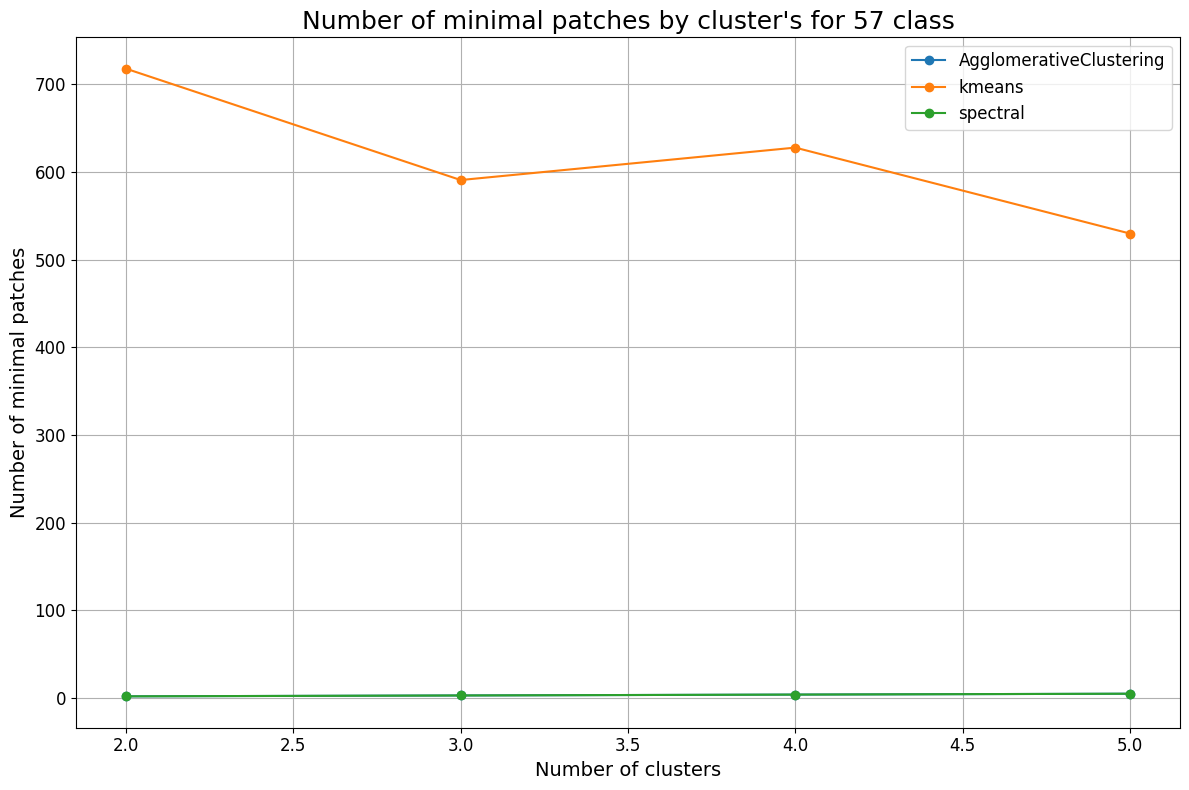

In [ ]:
import os
import json
import numpy as np
from collections import defaultdict
from PIL import Image
import cv2
# from scipy.spatial.distance import jensenshannon
from scipy.stats import wasserstein_distance as jensenshannon
from sklearn.cluster import AgglomerativeClustering, KMeans, SpectralClustering
from sklearn.metrics import silhouette_score
import matplotlib.pyplot as plt
from itertools import combinations

# Fix for Windows MKL memory leak warning
os.environ["OMP_NUM_THREADS"] = "1"

patch_size = (224, 224)
min_patch_area_ratio = 0.6
possible_clusters = range(2, 6)
use_rgb = False

def clustering_methods_analysis(class_folder, save_clusters):
    image_id_mapping = defaultdict(list)
    image_patch_counts = defaultdict(int)
    color_histograms = {}
    image_paths = {}
    dic_clusters = {}
    dic_clusters_patches = {}

    for classe in classes:
        dic_clusters[classe] = {}
        dic_clusters_patches[classe] = {}
    print(label_path)
    class_folder_path = os.path.join(label_path, class_folder)
    if os.path.isdir(class_folder_path):
        for image_name in os.listdir(class_folder_path):
            if image_name.lower().endswith(('png', 'jpg', 'jpeg')):
                image_id = image_name.split('_')[2].split('.')[0]
                image_path = os.path.join(class_folder_path, image_name)

                image = Image.open(image_path).convert("RGB")
                image_np = np.array(image)
                height, width = image_np.shape[:2]
                patch_count = max(1,(width // patch_size[0])) * max(1,(height // patch_size[1]))
                image_patch_counts[image_id] += patch_count

                if use_rgb:
                    hist = cv2.calcHist([image_np], [0, 1, 2], None, [50, 50, 50], [0, 256, 0, 256, 0, 256])
                else:
                    hsv_image = cv2.cvtColor(image_np, cv2.COLOR_RGB2HSV)
                    hist = cv2.calcHist([hsv_image], [0], None, [50], [0, 180])

                hist = cv2.normalize(hist, hist).flatten()

                color_histograms[image_path] = hist
                image_paths[image_path] = image_path
                image_id_mapping[image_id].append(image_path)

    image_ids = list(color_histograms.keys())
    hist_matrix = np.array([color_histograms[i] for i in image_ids])

    def check_cluster_constraints(clusters, image_ids, min_image_id_count=3):
        cluster_image_ids = defaultdict(set)
        for img_idx, cluster in enumerate(clusters):
            img_path = image_ids[img_idx]
            image_id = [key for key, val in image_id_mapping.items() if img_path in val][0]
            cluster_image_ids[cluster].add(image_id)

        return all(len(image_ids) >= min_image_id_count for image_ids in cluster_image_ids.values())
    



    def save_clusters_result(clusters, image_paths, image_ids, class_folder, method, num_clusters, folder_path="cluster_analysis_results"):
    
        # results dic
        result = {
            "method": method,
            "num_clusters": num_clusters,
            "class": class_folder,
            "clusters": {}
        }

        
        unique_clusters = set(clusters)
        for cluster in unique_clusters:
            result["clusters"][str(cluster)] = [
                image_paths[image_ids[i]] for i in range(len(image_ids)) if clusters[i] == cluster
            ]
        os.makedirs(folder_path, exist_ok=True)

        file_name = f"{method}_{class_folder}_{num_clusters}.json"
        file_path = os.path.join(folder_path, file_name)

        with open(file_path, "w") as f:
            json.dump(result, f, indent=4)


    # Distance matrix
    distance_matrix = np.zeros((len(image_ids), len(image_ids)))
    for i, j in combinations(range(len(image_ids)), 2):
        dist = jensenshannon(hist_matrix[i], hist_matrix[j])
        distance_matrix[i, j] = distance_matrix[j, i] = dist

    best_scores_hist_matrix = {'AgglomerativeClustering': [], #'AgglomerativeClusteringBase': [],
                            'KMeans++': [],# 'KMeans++Base': [], 
                            'SpectralClustering': []#,'SpectralClusteringBase': []}
    }

    best_scores_distance_matrix = {'AgglomerativeClustering': [],# 'AgglomerativeClusteringBase': [],
                                'KMeans++': [],# 'KMeans++Base': [], 
                                'SpectralClustering': []#, 'SpectralClusteringBase': []}
    }

    for num_clusters in possible_clusters:
        print(f"Testing with {num_clusters} clusters")
        
        agglomerative = AgglomerativeClustering(n_clusters=num_clusters, metric="precomputed", linkage="average")
        agglomerative_clusters = agglomerative.fit_predict(distance_matrix)
        if save_clusters:
            save_clusters_result(agglomerative_clusters, image_paths, image_ids, class_folder, "AgglomerativeClustering",num_clusters)

        if check_cluster_constraints(agglomerative_clusters, image_ids):
            best_scores_distance_matrix['AgglomerativeClustering'].append(silhouette_score(distance_matrix, agglomerative_clusters, metric="precomputed"))
            # best_scores_hist_matrix['AgglomerativeClustering'].append(silhouette_score(hist_matrix, agglomerative_clusters))
        else:
            best_scores_distance_matrix['AgglomerativeClustering'].append(np.nan)
            best_scores_hist_matrix['AgglomerativeClustering'].append(np.nan)
        

        # agglomerative_base = AgglomerativeClustering(n_clusters=num_clusters, linkage="average")
        # agglomerative_base_clusters = agglomerative_base.fit_predict(hist_matrix)
        # if save_clusters:
        #     save_clusters_result(agglomerative_base_clusters, image_paths, image_ids, class_folder, "AgglomerativeClusteringBase",num_clusters)

        # if check_cluster_constraints(agglomerative_base_clusters, image_ids):
        #     best_scores_hist_matrix['AgglomerativeClusteringBase'].append(silhouette_score(hist_matrix, agglomerative_base_clusters))
        #     best_scores_distance_matrix['AgglomerativeClusteringBase'].append(silhouette_score(distance_matrix, agglomerative_base_clusters, metric="precomputed"))
        # else:
        #     best_scores_hist_matrix['AgglomerativeClusteringBase'].append(np.nan)
        #     best_scores_distance_matrix['AgglomerativeClusteringBase'].append(np.nan)


        # # KMeans++ with histograms
        # kmeans = KMeans(n_clusters=num_clusters, init='k-means++', random_state=42)
        # kmeans.fit(hist_matrix)
        # kmeans_clusters = kmeans.labels_
        # if save_clusters:
        #     save_clusters_result(kmeans_clusters, image_paths, image_ids, class_folder, "kmeansBase",num_clusters)

        # if check_cluster_constraints(kmeans_clusters, image_ids):
        #     best_scores_hist_matrix['KMeans++Base'].append(silhouette_score(hist_matrix, kmeans_clusters))
        #     best_scores_distance_matrix['KMeans++Base'].append(silhouette_score(distance_matrix, kmeans_clusters, metric="precomputed"))
        # else:
        #     best_scores_hist_matrix['KMeans++Base'].append(np.nan)
        #     best_scores_distance_matrix['KMeans++Base'].append(np.nan)

        # KMeans++ matrix distances
        kmeans_distance = KMeans(n_clusters=num_clusters, init='k-means++', random_state=42)
        kmeans_distance.fit(distance_matrix)
        kmeans_distance_clusters = kmeans_distance.labels_
        if save_clusters:
            save_clusters_result(kmeans_distance_clusters, image_paths, image_ids, class_folder, "kmeans",num_clusters)

        if check_cluster_constraints(kmeans_distance_clusters, image_ids):
            # best_scores_hist_matrix['KMeans++'].append(silhouette_score(hist_matrix, kmeans_distance_clusters))
            best_scores_distance_matrix['KMeans++'].append(silhouette_score(distance_matrix, kmeans_distance_clusters, metric="precomputed"))
        else:
            best_scores_hist_matrix['KMeans++'].append(np.nan)
            best_scores_distance_matrix['KMeans++'].append(np.nan)

        # Spectral Clustering matrix distances
        spectral = SpectralClustering(n_clusters=num_clusters, affinity="precomputed", random_state=42)
        spectral_clusters = spectral.fit_predict(distance_matrix)
        if save_clusters:
            save_clusters_result(spectral_clusters, image_paths, image_ids, class_folder, "spectral",num_clusters)

        if check_cluster_constraints(spectral_clusters, image_ids):
            # best_scores_hist_matrix['SpectralClustering'].append(silhouette_score(hist_matrix, spectral_clusters))
            best_scores_distance_matrix['SpectralClustering'].append(silhouette_score(distance_matrix, spectral_clusters, metric="precomputed"))
        else:
            best_scores_hist_matrix['SpectralClustering'].append(np.nan)
            best_scores_distance_matrix['SpectralClustering'].append(np.nan)

        # Spectral Clustering with histograms
        # spectral_base = SpectralClustering(n_clusters=num_clusters, affinity="nearest_neighbors", random_state=42)
        # spectral_base_clusters = spectral_base.fit_predict(hist_matrix)
        # if save_clusters:
        #     save_clusters_result(spectral_base_clusters, image_paths, image_ids, class_folder, "spectralBase",num_clusters)


        # if check_cluster_constraints(spectral_base_clusters, image_ids):
        #     best_scores_hist_matrix['SpectralClusteringBase'].append(silhouette_score(hist_matrix, spectral_base_clusters))
        #     best_scores_distance_matrix['SpectralClusteringBase'].append(silhouette_score(distance_matrix, spectral_base_clusters, metric="precomputed"))
        # else:
        #     best_scores_hist_matrix['SpectralClusteringBase'].append(np.nan)
        #     best_scores_distance_matrix['SpectralClusteringBase'].append(np.nan)


    methods = best_scores_hist_matrix.keys()
    plt.figure(figsize=(12, 8))

    # Taille personnalisée
    title_fontsize = 18
    label_fontsize = 14
    legend_fontsize = 12

    for method in methods:
        print(method)
        plt.plot(possible_clusters, best_scores_distance_matrix[method], label=method)

    plt.title(f"Silhouette Scores class {class_folder}", fontsize=title_fontsize)
    plt.xlabel("Number of Clusters", fontsize=label_fontsize)
    plt.ylabel("Silhouette Score", fontsize=label_fontsize)
    plt.legend(fontsize=legend_fontsize)
    plt.grid(True)

    plt.tight_layout()
    plt.savefig(f"Silouhette_scores2_{class_folder}_HSV.png")
    plt.show()


for class_folder in classes:
    if class_folder == "2":
        print(f"-----Processing for {class_folder} class ... ------")
        clustering_methods_analysis(class_folder, True)

    else:
        continue


def compute_variance(cluster_sizes):
    return np.var(cluster_sizes)


def compute_entropy(cluster_sizes):
    total = sum(cluster_sizes)
    probabilities = np.array(cluster_sizes) / total
    return -np.sum(probabilities * np.log2(probabilities + 1e-10))

def compute_entropy(cluster_sizes):
    total = sum(cluster_sizes)
    probabilities = np.array(cluster_sizes) / total
    return -np.sum(probabilities * np.log2(probabilities + 1e-10))

def analyze_cluster_variance(results_folder, patches_count_file):

    with open(patches_count_file, 'r') as f:
        patches_count = json.load(f)
    
    data = defaultdict(lambda: defaultdict(lambda: defaultdict(list)))
    min_values = defaultdict(lambda: defaultdict(lambda: defaultdict(list)))
    

    for file in os.listdir(results_folder):
        if file.endswith(".json") and file != "patches_count.json":
            file_path = os.path.join(results_folder, file)
            with open(file_path, 'r') as f:
                cluster_data = json.load(f)
            
            method = cluster_data["method"]
            num_clusters = cluster_data["num_clusters"]
            class_label = cluster_data["class"]
            
            cluster_sizes = []
            for cluster in cluster_data["clusters"].values():
                cluster_size = sum(patches_count.get(img_path.replace('\\','/'), 0) for img_path in cluster)
                cluster_sizes.append(cluster_size)
            
            min_cluster_size = min(cluster_sizes)
            print(min_cluster_size, method, num_clusters, class_label)
            variance = compute_entropy(cluster_sizes)
     
            data[class_label][method][num_clusters].append(variance)
            min_values[class_label][method][num_clusters].append(min_cluster_size)
    

    for class_label in data:
        for method in data[class_label]:
            for num_clusters in data[class_label][method]:
                data[class_label][method][num_clusters] = np.mean(data[class_label][method][num_clusters])
                min_values[class_label][method][num_clusters] = np.mean(min_values[class_label][method][num_clusters])
    
    for class_label, methods in data.items():
        plt.figure(figsize=(12, 8))

        # Dé        finition des tailles de police
        title_fontsize = 18
        label_fontsize = 14
        legend_fontsize = 12
        ticks_fontsize = 12

        for method, variances in methods.items():
            if "Base" in method:
                continue
            sorted_clusters = sorted(variances.keys())
            sorted_mins = [min_values[class_label][method][k] for k in sorted_clusters]
            for i in range(len(sorted_mins)):
                sorted_mins[i] *= (i + 2)

            plt.plot(sorted_clusters[0:5], sorted_mins[0:5], marker='o', label=method)

        plt.xlabel("Number of clusters", fontsize=label_fontsize)
        plt.ylabel("Number of minimal patches", fontsize=label_fontsize)
        plt.title(f"Number of minimal patches by cluster's for {class_label} class", fontsize=title_fontsize)
        plt.xticks(fontsize=ticks_fontsize)
        plt.yticks(fontsize=ticks_fontsize)
        plt.legend(fontsize=legend_fontsize)
        plt.grid()

        plt.tight_layout()
        plt.savefig(f"entropy_by_classes2_{class_label}.pdf")
        plt.show()


analyze_cluster_variance("cluster_analysis_results", "patches_count.json")

In [ ]:
import os
import numpy as np
from collections import defaultdict
from PIL import Image
import cv2
from scipy.spatial.distance import jensenshannon
from sklearn.cluster import AgglomerativeClustering, KMeans, SpectralClustering
from sklearn.metrics import silhouette_score

from itertools import combinations


def find_optimal_repartition(dic_clusters, dic_clusters_patches, class_folder, dic_clusters_patches_opti, nb_clusters, dic_clusters_opti, dic_methods):
    print(f"----------running {class_folder} class ...... -----------------")


    color_histograms = {}
    image_paths = {}
    image_id_mapping = defaultdict(list)
    image_patch_counts = defaultdict(int)

    class_folder_path = os.path.join(label_path, class_folder)
    if os.path.isdir(class_folder_path):
        for image_name in os.listdir(class_folder_path):
            if image_name.lower().endswith(('png', 'jpg', 'jpeg')):
                image_id = image_name.split('_')[2].split('.')[0]
                image_path = os.path.join(class_folder_path, image_name)

                
                
                image = Image.open(image_path).convert("RGB")
                image_np = np.array(image)
                height, width = image_np.shape[:2]
                patch_count = max(1,(width // patch_size[0])) * max(1,(height // patch_size[1]))
                image_patch_counts[image_id] += patch_count
                dic_clusters_patches_opti[image_path] = {"image_id":image_id, "patches":patch_count,"cluster":np.NaN}
                
                if use_rgb:
                    hist = cv2.calcHist([image_np], [0, 1, 2], None, [50, 50, 50], [0, 256, 0, 256, 0, 256])
                else:
                    hsv_image = cv2.cvtColor(image_np, cv2.COLOR_RGB2HSV)
                    hist = cv2.calcHist([hsv_image], [0], None, [50], [0, 180])
                
                hist = cv2.normalize(hist, hist).flatten()
                
                color_histograms[image_path] = hist
                image_paths[image_path] = image_path
                image_id_mapping[image_id].append(image_path)

    image_ids = list(color_histograms.keys())
    hist_matrix = np.array([color_histograms[i] for i in image_ids])

    def check_cluster_constraints(clusters, image_ids, min_image_id_count=3):
        cluster_image_ids = defaultdict(set)
        for img_idx, cluster in enumerate(clusters):
            img_path = image_ids[img_idx]
            image_id = [key for key, val in image_id_mapping.items() if img_path in val][0]
            cluster_image_ids[cluster].add(image_id)
        
        return all(len(image_ids) >= min_image_id_count for image_ids in cluster_image_ids.values())
    

    distance_matrix = np.zeros((len(image_ids), len(image_ids)))
    for i, j in combinations(range(len(image_ids)), 2):
        dist = jensenshannon(hist_matrix[i], hist_matrix[j])
        distance_matrix[i, j] = distance_matrix[j, i] = dist


    method =  dic_methods[class_folder]["method"]
    num_clusters = dic_methods[class_folder]["num_clusters"]
    print(f" using {method} for {class_folder} class for {num_clusters} clusters")


    if method == "AgglomerativeClustering":
    
        agglomerative = AgglomerativeClustering(n_clusters=num_clusters, metric="precomputed", linkage="average")
        clusters = agglomerative.fit_predict(distance_matrix)

    elif method == "AgglomerativeClusteringBase":
        agglomerative_base = AgglomerativeClustering(n_clusters=num_clusters, linkage="average")
        clusters = agglomerative_base.fit_predict(hist_matrix)

    elif method =="kmeansBase":
        kmeans = KMeans(n_clusters=num_clusters, init='k-means++', random_state=42)
        kmeans.fit(hist_matrix)
        clusters = kmeans.labels_

    elif method == "kmeans":
        kmeans_distance = KMeans(n_clusters=num_clusters, init='k-means++', random_state=42)
        kmeans = kmeans_distance.fit(distance_matrix)
        clusters = kmeans.labels_

    elif method == "spectral":
        spectral = SpectralClustering(n_clusters=num_clusters, affinity="precomputed", random_state=42)
        clusters = spectral.fit_predict(distance_matrix)
    
    else:
        spectral_base = SpectralClustering(n_clusters=num_clusters, affinity="nearest_neighbors", random_state=42)
        clusters = spectral_base.fit_predict(hist_matrix)


    for i in range(len(image_ids)):
         dic_clusters_patches_opti[image_paths[image_ids[i]]]["cluster"] = str(clusters[i] + nb_clusters)



    for cluster in clusters:

        filtered_images = [image_paths[image_ids[i]] for i in range(len(image_ids)) if clusters[i] == cluster]
        dic_clusters_opti[str(cluster + nb_clusters)] = filtered_images
     
        cluster_image_ids = set(
            [key for img in filtered_images for key, val in image_id_mapping.items() if img in val]
        )
        l = []
        for img_id in cluster_image_ids:
            l.append(image_patch_counts[img_id])

        dic_clusters[class_folder][cluster] = list(cluster_image_ids)
        dic_clusters_patches[class_folder][cluster] = l.copy()

    return num_clusters


# Fix for Windows MKL memory leak warning
os.environ["OMP_NUM_THREADS"] = "1"


patch_size = (224, 224)
min_patch_area_ratio = 0.6
possible_clusters = range(2, 6)
use_rgb = False


dic_clusters = {}
dic_clusters_patches = {}
dic_clusters_opti = {}
dic_clusters_patches_opti = {}
dic_methods = {"1" : {"method":"kmeansBase", "num_clusters": 2},
               "2":{"method":"kmeans", "num_clusters": 4},
               "3":{"method":"kmeans", "num_clusters": 5},
               "41":{"method":"spectralBase", "num_clusters": 3},
               "42":{"method":"kmeans", "num_clusters": 3},
               "51":{"method":"kmeansBase", "num_clusters": 3},
               "52":{"method":"kmeansBase", "num_clusters": 3},
               "54":{"method":"kmeansBase", "num_clusters": 3},
               "57":{"method":"kmeansBase", "num_clusters": 3}}


if label_path == "labels_low_res/":
    dic_methods = {"1" : {"method":"kmeansBase", "num_clusters": 2},
               "2":{"method":"kmeans", "num_clusters": 4},
               "3":{"method":"kmeans", "num_clusters": 5},
               "41":{"method":"spectralBase", "num_clusters": 3},
               "5":{"method":"kmeansBase", "num_clusters": 3}}


for classe in classes:
    dic_clusters[classe] = {}
    dic_clusters_patches[classe] = {}
   
nb_clusters = 0
for class_folder in classes:
    nb_clusters += find_optimal_repartition(dic_clusters, dic_clusters_patches, class_folder, dic_clusters_patches_opti, nb_clusters, dic_clusters_opti, dic_methods)
    

def normalize_path(path):
    return os.path.normpath(path).replace("\\", "/")




images = {normalize_path(k): v for k, v in dic_clusters_patches_opti.items()}
clusters = {k: [normalize_path(p) for p in v] for k, v in dic_clusters_opti.items()}

save_dict(images,"images.json")
save_dict(clusters, "clusters.json")

----------running 1 class ...... -----------------
 using kmeansBase for 1 class for 2 clusters
----------running 2 class ...... -----------------
 using kmeans for 2 class for 4 clusters
----------running 3 class ...... -----------------
 using kmeans for 3 class for 5 clusters
----------running 41 class ...... -----------------
 using spectralBase for 41 class for 3 clusters
----------running 42 class ...... -----------------
 using kmeans for 42 class for 3 clusters
----------running 51 class ...... -----------------
 using kmeansBase for 51 class for 3 clusters
----------running 52 class ...... -----------------
 using kmeansBase for 52 class for 3 clusters
----------running 54 class ...... -----------------
 using kmeansBase for 54 class for 3 clusters
----------running 57 class ...... -----------------
 using kmeansBase for 57 class for 3 clusters
images.json saved
clusters.json saved


### Problème d'optimisation sous la contrainte que tous les patches d'une même WSI se retrouvent dans une partition du dataset

Performing random optimization repartition ...
==== adding random constraint in optimization    
Image labels1/1/1_10_13.png -> train
Image labels1/1/1_110_26.png -> val
Image labels1/1/1_111_26.png -> val
Image labels1/1/1_11_17.png -> train
Image labels1/1/1_13_17.png -> train
Image labels1/1/1_157_11.png -> train
Image labels1/1/1_20_5.png -> train
Image labels1/1/1_21_17.png -> train
Image labels1/1/1_21_5.png -> train
Image labels1/1/1_22_0.png -> val
Image labels1/1/1_22_3.png -> test
Image labels1/1/1_25_17.png -> train
Image labels1/1/1_25_4.png -> train
Image labels1/1/1_26_4.png -> train
Image labels1/1/1_27_4.png -> train
Image labels1/1/1_35_8.png -> val
Image labels1/1/1_42_6.png -> test
Image labels1/1/1_43_6.png -> test
Image labels1/1/1_50_3.png -> test
Image labels1/1/1_51_3.png -> test
Image labels1/1/1_52_3.png -> test
Image labels1/1/1_53_3.png -> test
Image labels1/1/1_54_3.png -> test
Image labels1/1/1_55_3.png -> test
Image labels1/1/1_56_12.png -> val
Image labe

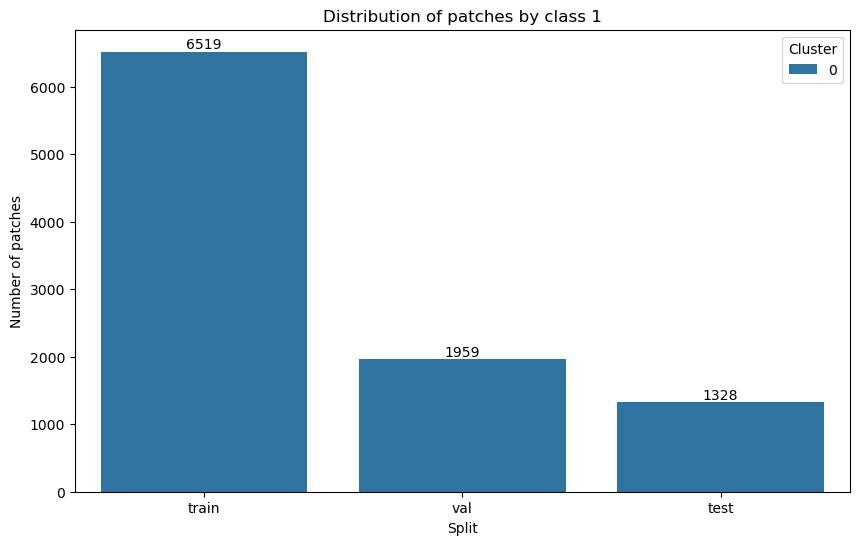

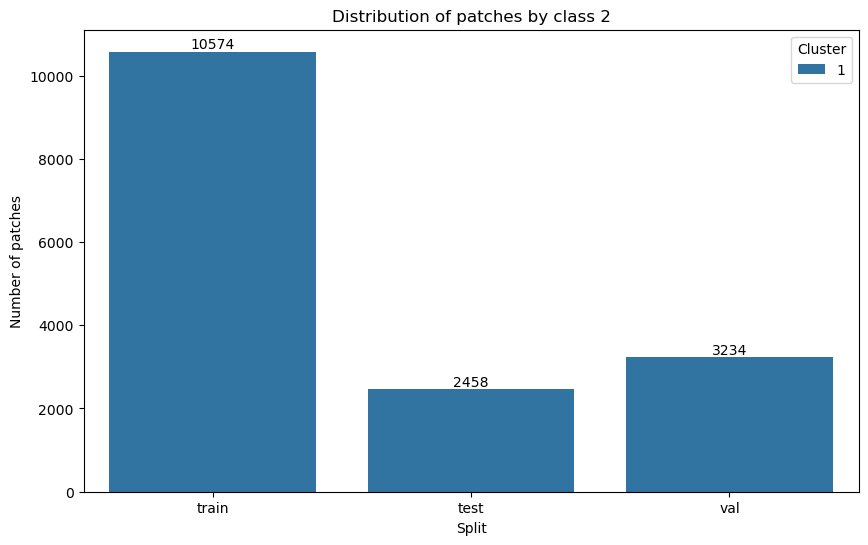

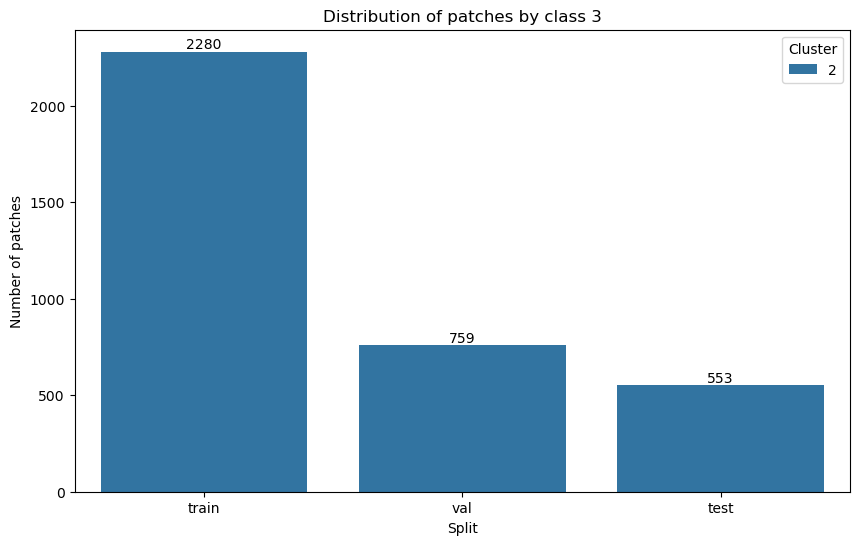

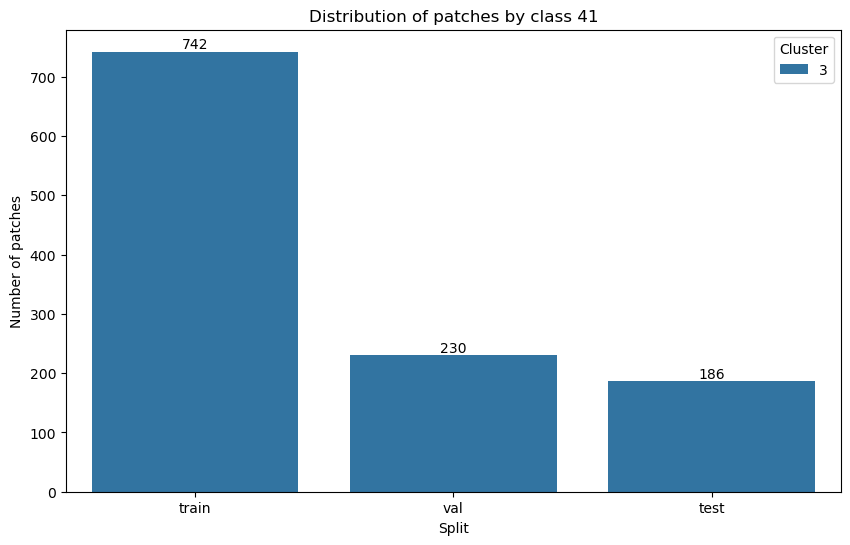

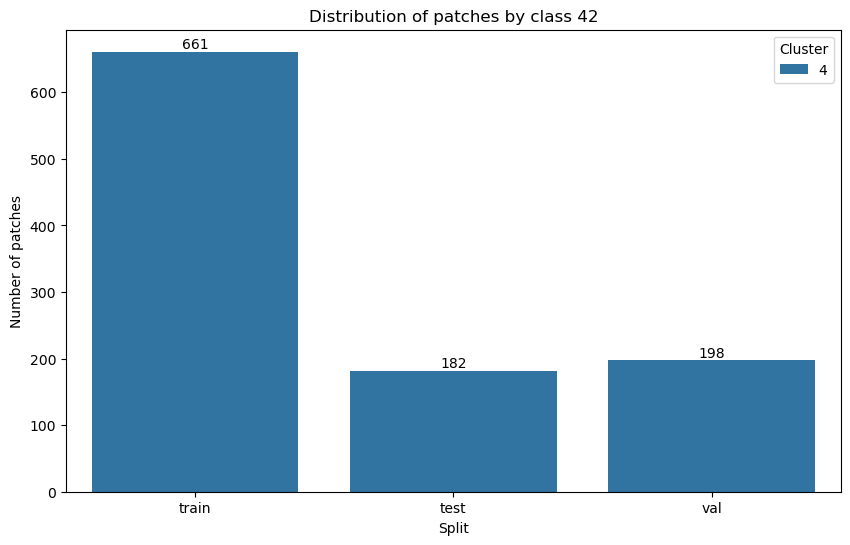

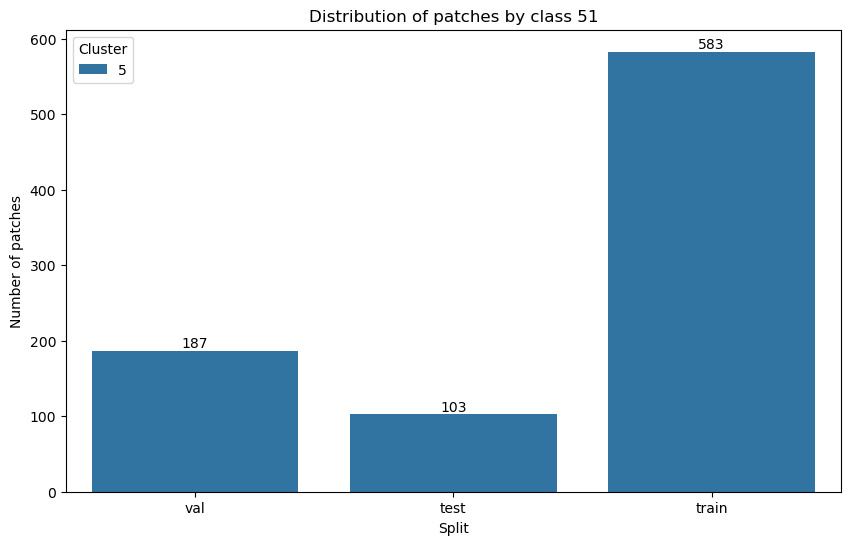

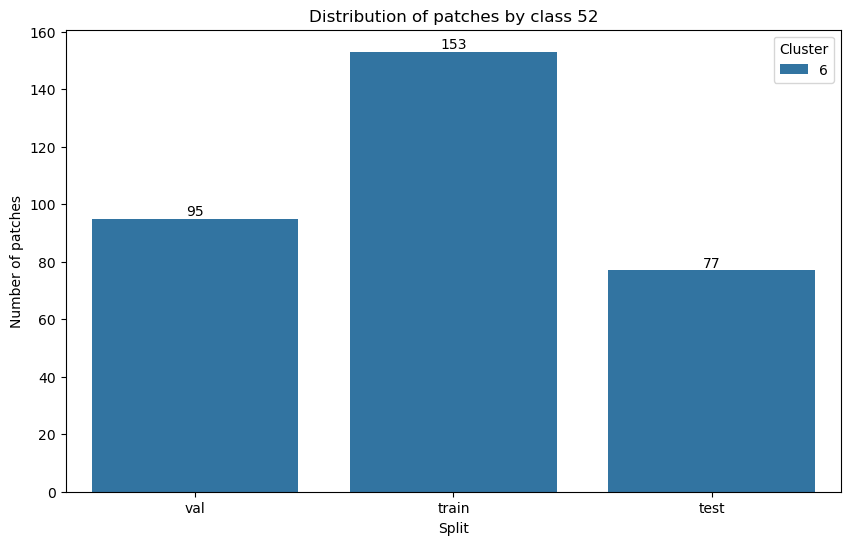

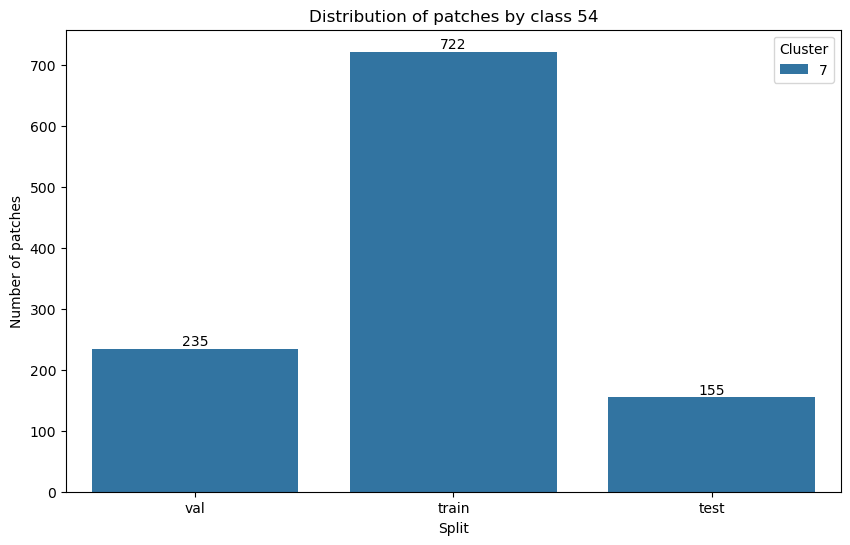

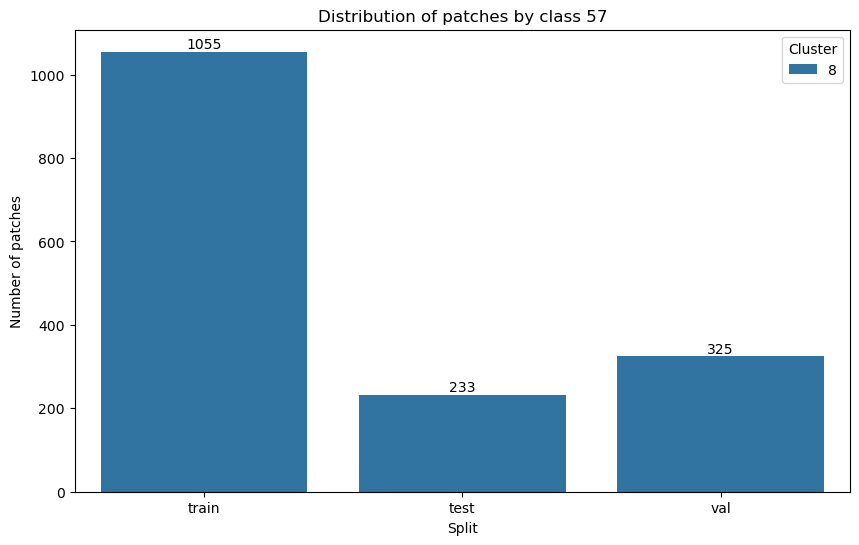

In [ ]:
import json
import pulp as lp
import os
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd


def repartition_optimization(images, clusters, random_opti = ''):
    splits = ['train', 'val', 'test']
    model = lp.LpProblem("Image_Split_Optimization", lp.LpMinimize)

    x = {(i, s): lp.LpVariable(f"x_{i}_{s}", cat=lp.LpBinary) for i in images for s in splits}
    P_cs = {(c, s): lp.LpVariable(f"P_{c}_{s}", cat=lp.LpContinuous) for c in clusters for s in splits}

    for i in images:
        model += lp.lpSum(x[i, s] for s in splits) == 1, f"assign_{i}"
    
    if random_opti =="random_":
        print("==== adding random constraint in optimization    ")
    
        rdm_constraint = load_dict(f"repartition_labels.json")
        
        # for i in images:
            
        #     ori_img = i.split('/')[-1].split('_')[-1][:-4]
        #     split = rdm_constraint[ori_img]
        #     if split == "test":
        #         model += x[i,'test'] == 0, f"assign_random_{i}_test"
        #         model += x[i,'train'] == 1, f"assign_random_{i}_train"
        #         model += x[i,'val'] == 0,  f"assign_random_{i}_val"
        #     else:
        #         model += x[i,'train'] == 0, f"assign_random_{i}_test"

    image_ids = {}
    for i, img in images.items():
        if img['image_id'] not in image_ids:
            image_ids[img['image_id']] = []
        image_ids[img['image_id']].append(i)

    for id_images in image_ids.values():
        # for s in ["test"]:
        for s in splits:
            for i in id_images:
                for j in id_images:
                    model += x[i, s] == x[j, s], f"same_id_{i}_{j}_{s}"

    for c, image_list in clusters.items():
        for s in splits:
            model += P_cs[c, s] == lp.lpSum(images[str(i)]['patches'] * x[i, s] for i in image_list), f"patches_{c}_{s}"
            model += lp.lpSum(x[i, s] for i in image_list) >= 1, f"min_one_image_{c}_{s}"

    split_ratios = {'train': 0.65, 'val': 0.2, 'test': 0.15}

    P_target_cs = {c: {s: sum(images[i]['patches'] for i in clusters[c]) * split_ratios[s] for s in splits} for c in clusters}


    error = {(c, s): lp.LpVariable(f"error_{c}_{s}", lowBound=0) for c in clusters for s in splits}

    for c in clusters:
        # for s in ["val","test"]:
        # if c in ["5","6"]:
        for s in splits:
            model += error[c, s] >= P_cs[c, s] - P_target_cs[c][s]
            model += error[c, s] >= -(P_cs[c, s] - P_target_cs[c][s])

    objective = lp.lpSum(error[c, s] for c in clusters for s in splits)

    model += objective
    model.solve(lp.PULP_CBC_CMD(msg=True))


    res = {}
    results = {}
    patch_counts = {s: 0 for s in splits}

    images_reparted = {}

    if lp.LpStatus[model.status] == "Optimal":
        for i in images:
            class_id = i.split("/")[1]
            cluster = images[i]["cluster"]
            patches = images[i]["patches"]
            for s in splits:
                if x[i, s].varValue > 0.5:
                    print(f"Image {i} -> {s}")
                    images_reparted[i] = {"cluster": cluster, "patches": patches, "class_id": class_id, "split": s}
                    results.setdefault(class_id, {}).setdefault(cluster, {}).setdefault(s, 0)
                    results[class_id][cluster][s] += patches
                    
                    num_patches = images[i]['patches']
                    patch_counts[s] += num_patches
                    
                    final_img_id = i.split('_')[2].split('.')[0]
                    if label_path == "labels_low_res/":
                        final_img_id = i.split('/')[2].split('.')[0].split('_')[2]
                
                    if final_img_id in res and res[final_img_id] != s:
                        print('PROBLEME')
                    else:
                        res[final_img_id] = s

    
    save_dict(res, f"{random_opti}repartition_labels.json")
    save_dict(images_reparted, f"{random_opti}image_reparted.json")
    save_dict(results, f"{random_opti}results.json")

    print("Objective value :", model.objective.value())

    total_patches = sum(patch_counts.values())
    if total_patches > 0:
        patch_proportions = {s: patch_counts[s] / total_patches * 100 for s in splits}
    else:
        patch_proportions = {s: 0 for s in splits}

    print("\n Nb patches by split :")
    for s in splits:
        print(f"{s}: {patch_counts[s]} patches ({patch_proportions[s]:.2f}%)")


    for class_id, clusters in results.items():
        plt.figure(figsize=(10, 6))
        df = []
        
        for cluster, splits in clusters.items():
            for split, count in splits.items():
                df.append({"Split": split, "Patches": count, "Cluster": cluster})
        
        df = pd.DataFrame(df)
        
        ax = sns.barplot(x="Split", y="Patches", hue="Cluster", data=df)
        
        for p in ax.patches:
            ax.annotate(f'{int(p.get_height())}', 
                        (p.get_x() + p.get_width() / 2., p.get_height()), 
                        ha='center', va='bottom', fontsize=10, color='black')

        plt.title(f"Distribution of patches by class {class_id}")
        plt.xlabel("Split")
        plt.ylabel("Number of patches")
        plt.legend(title="Cluster")
        plt.savefig(f"{random_opti}repartition_patches_class_{class_id}.pdf")
        plt.show()
    



true_opti ="random_"
# true_opti = ""

images = load_dict("images.json")
clusters = load_dict("clusters.json")


if true_opti == "random_":
    print("Performing random optimization repartition ...")
    ###Random optimization
    clusters = {}

   
    for image_path, data in images.items():
        # for image_id, patches, cluster in data.values():
        cluster = str(classes.index(image_path.split('/')[1]))
        images[image_path]["cluster"] = cluster
        if cluster in clusters:
            clusters[cluster] += [image_path]
        else:
            clusters[cluster] = [image_path]


# print(images)
# print(clusters)
repartition_optimization(images, clusters, true_opti)




### On équilibre la dataset avec les résultats d'optimisation en terme de nombre de patches entre les classes. Cette section de code sert juste à enregistrer le nombre de patches attendus par classe et ces données seront ensuite utilisées pour créer concrètement nos folders de train val et test au code suivant.

150
95
77


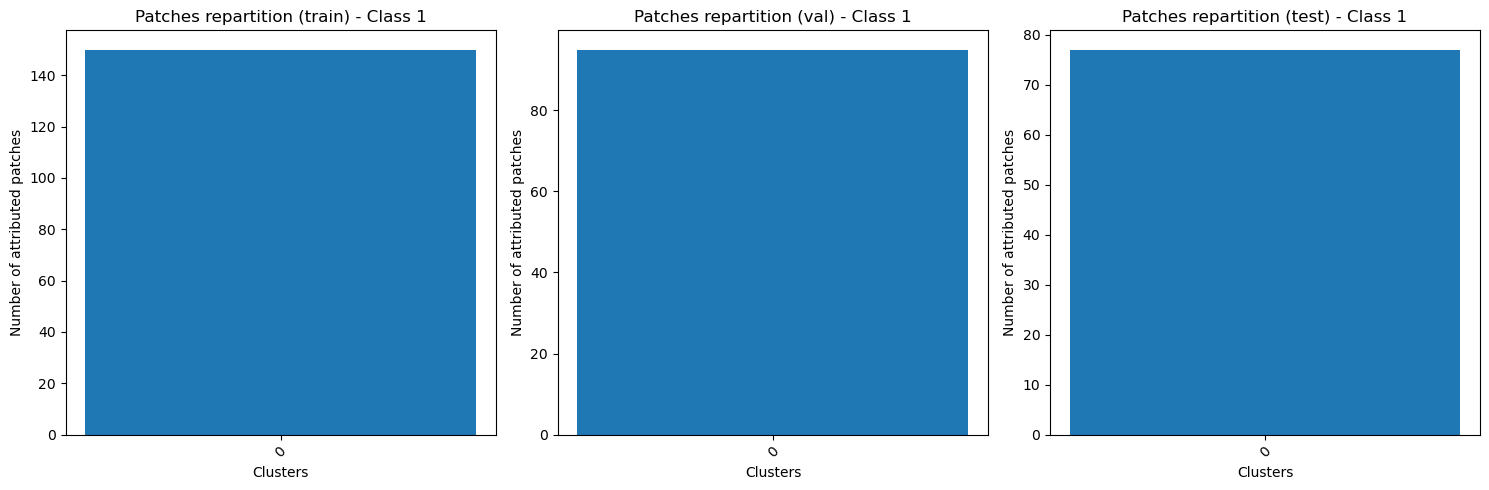

150
95
77


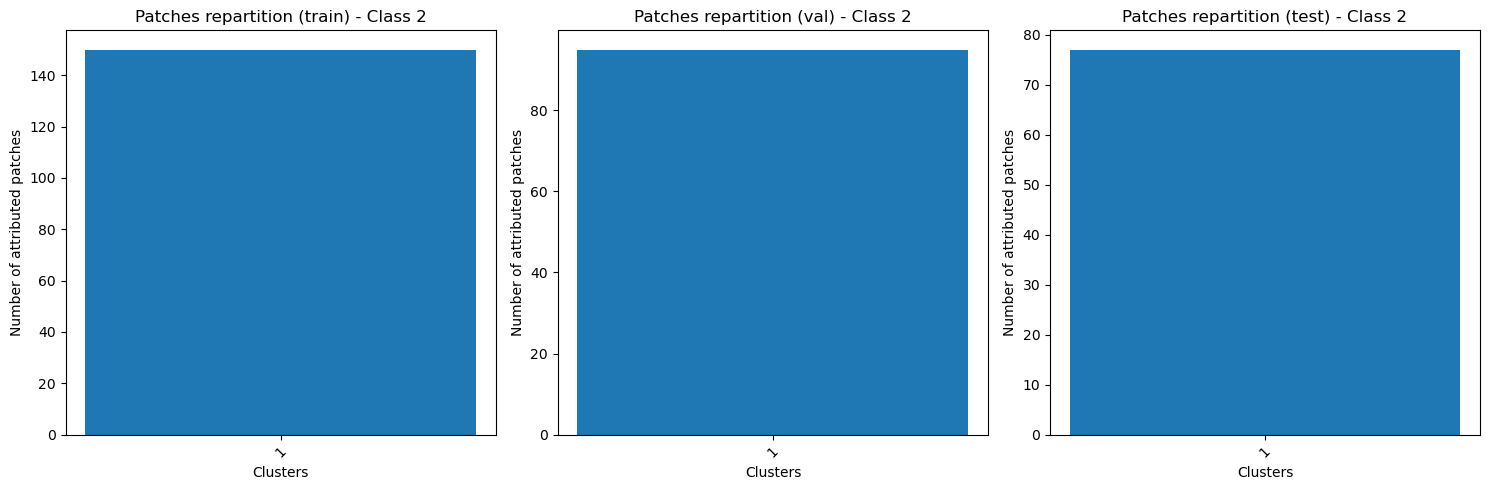

150
95
77


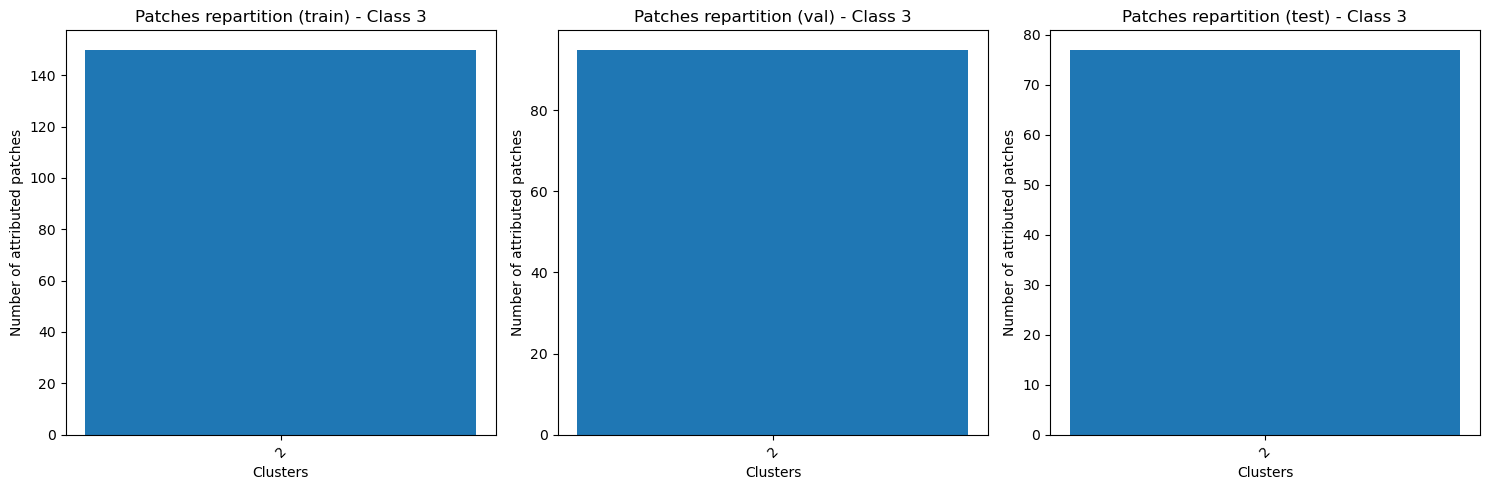

150
95
77


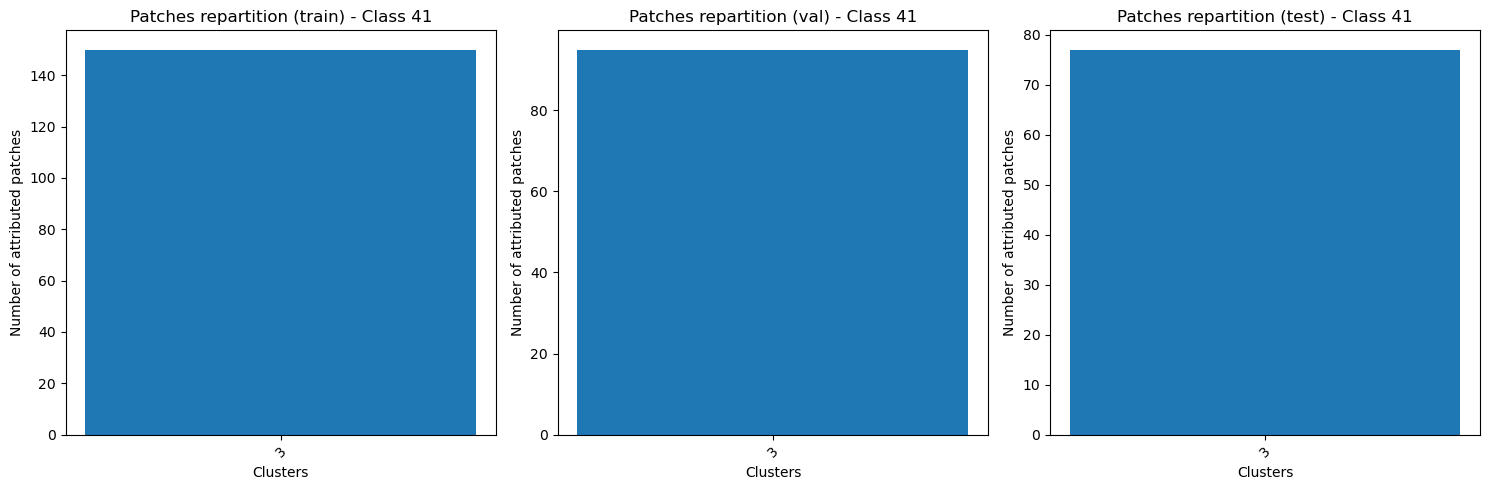

150
95
77


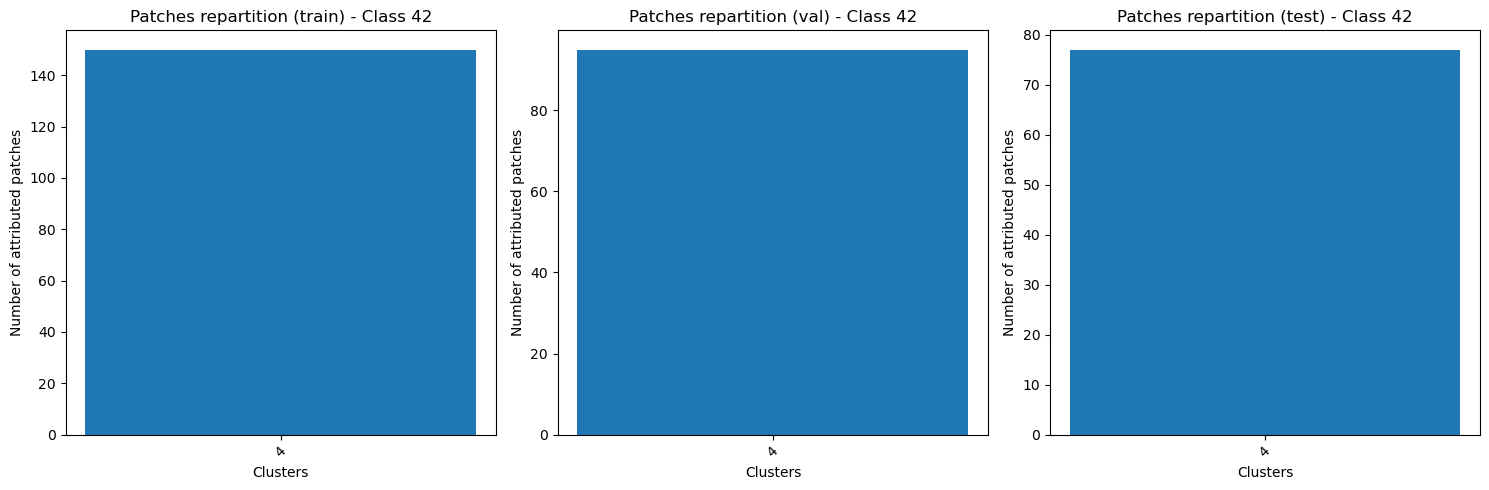

150
95
77


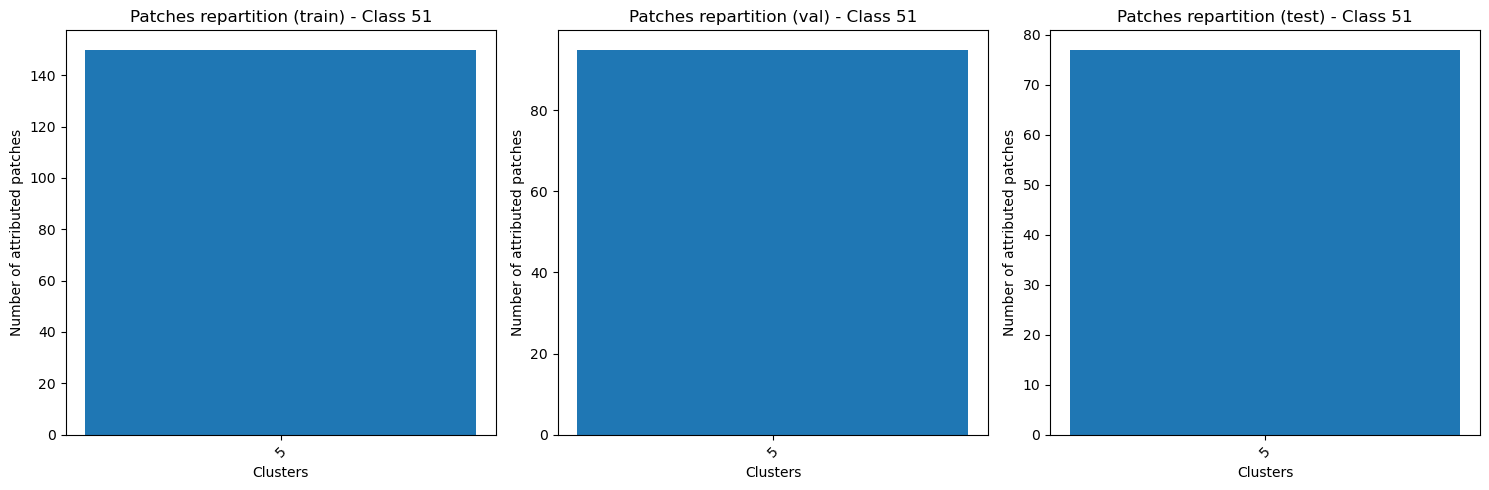

150
95
77


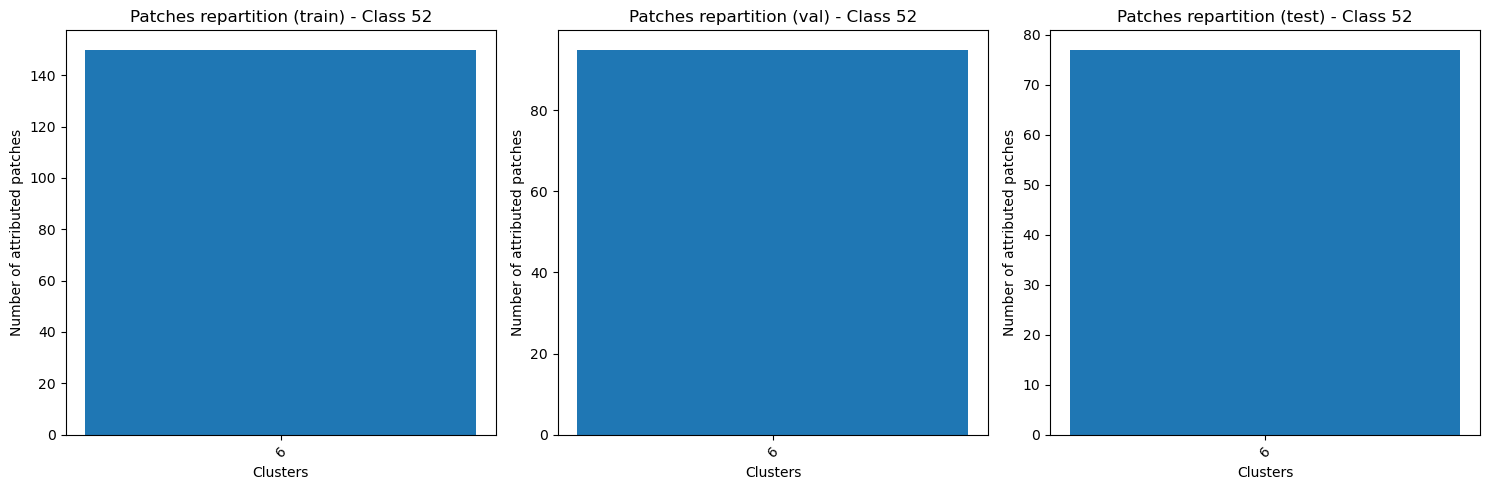

150
95
77


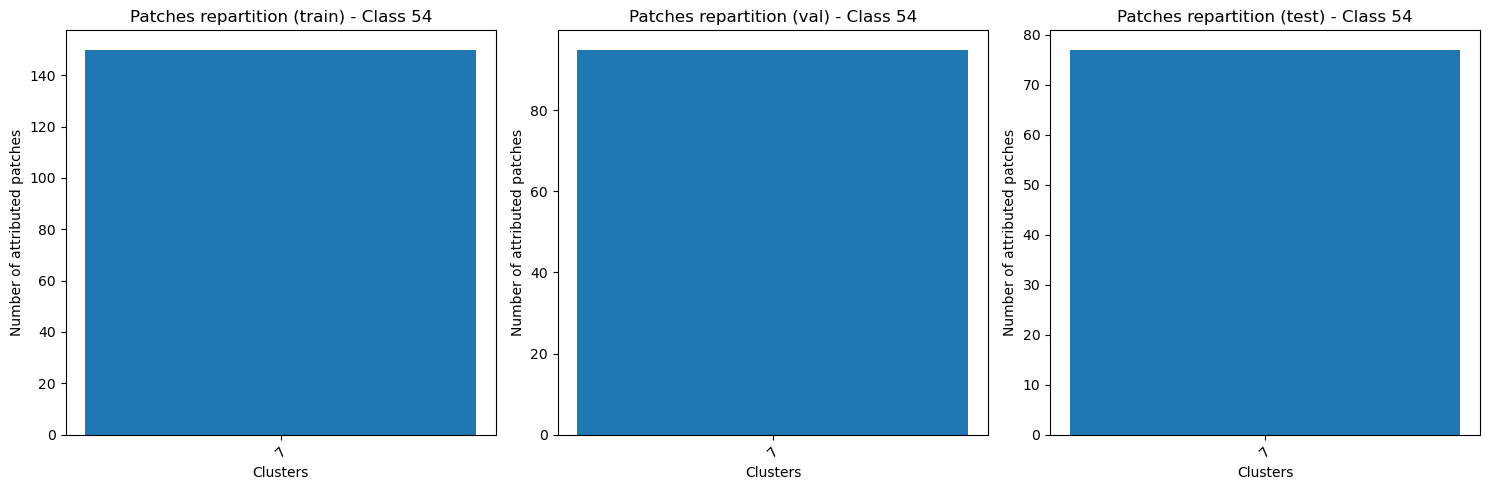

150
95
77


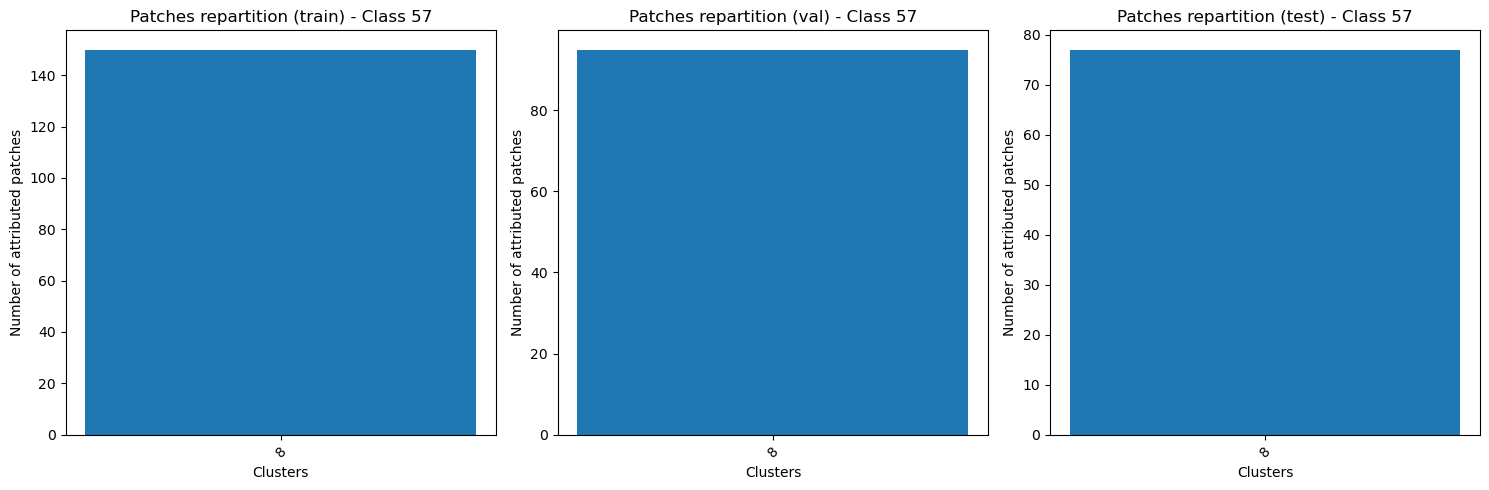

<Figure size 1200x600 with 0 Axes>

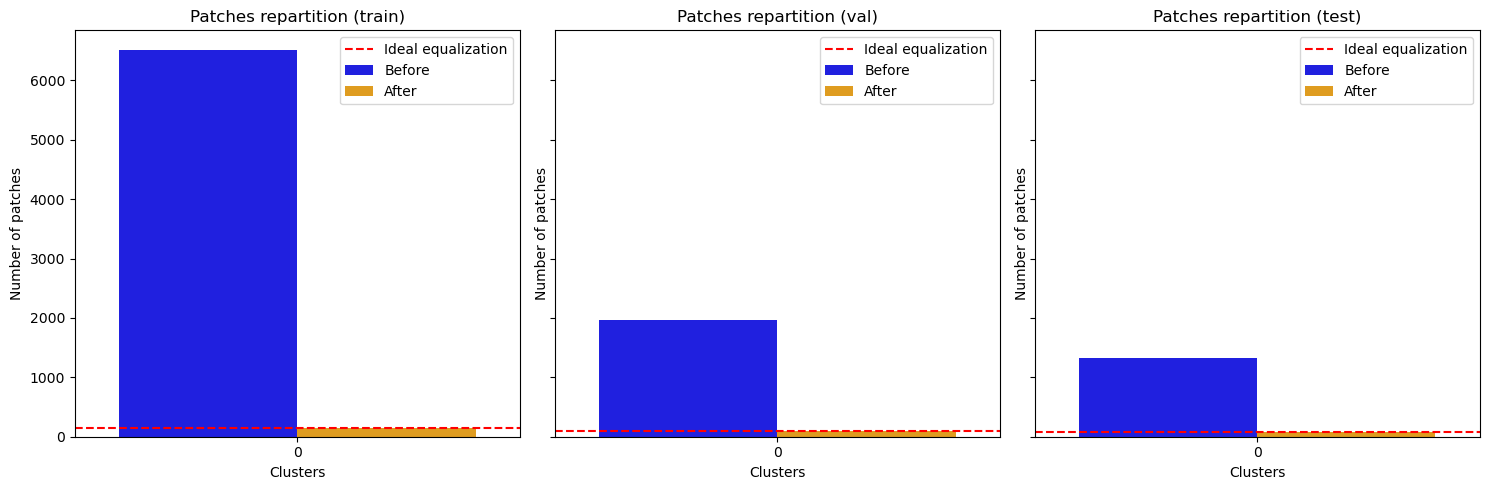

<Figure size 1200x600 with 0 Axes>

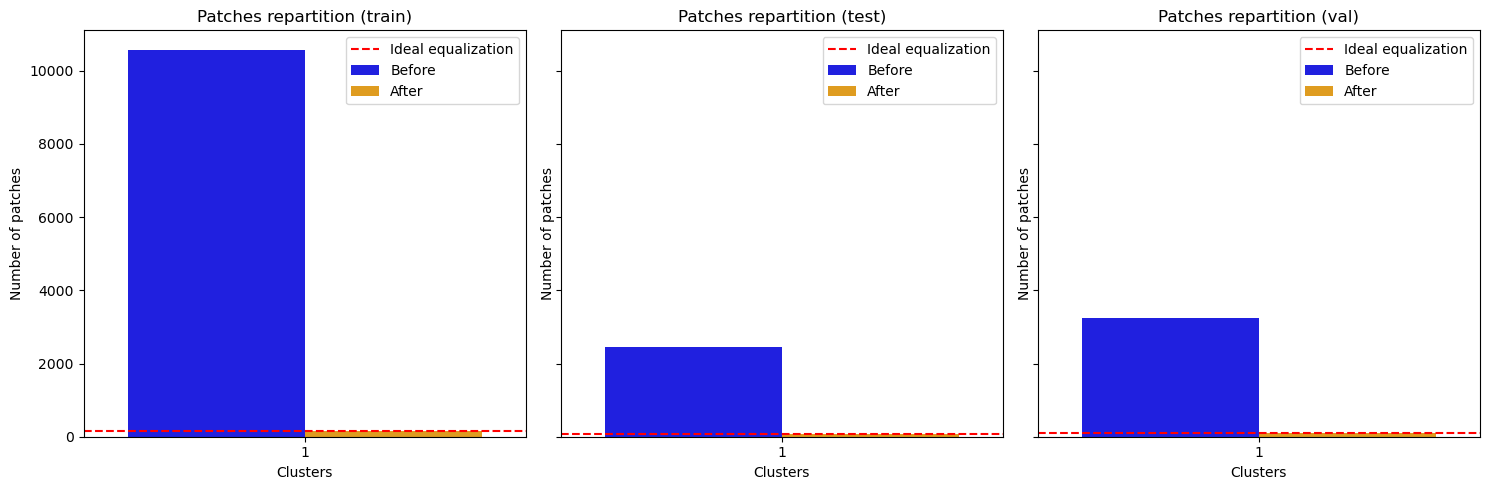

<Figure size 1200x600 with 0 Axes>

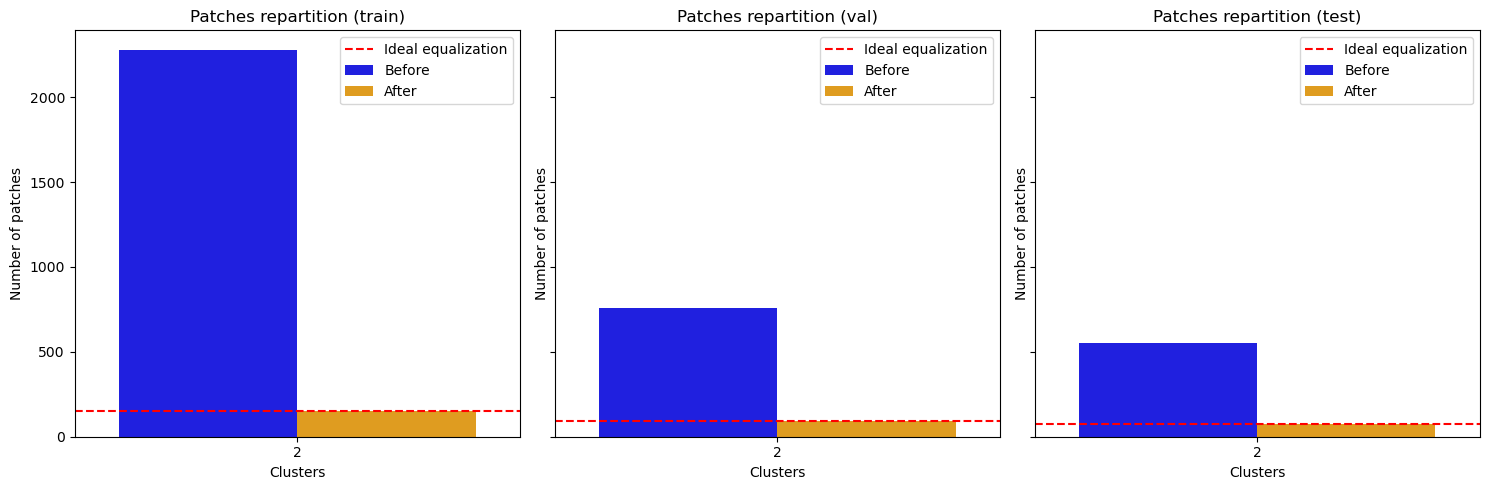

<Figure size 1200x600 with 0 Axes>

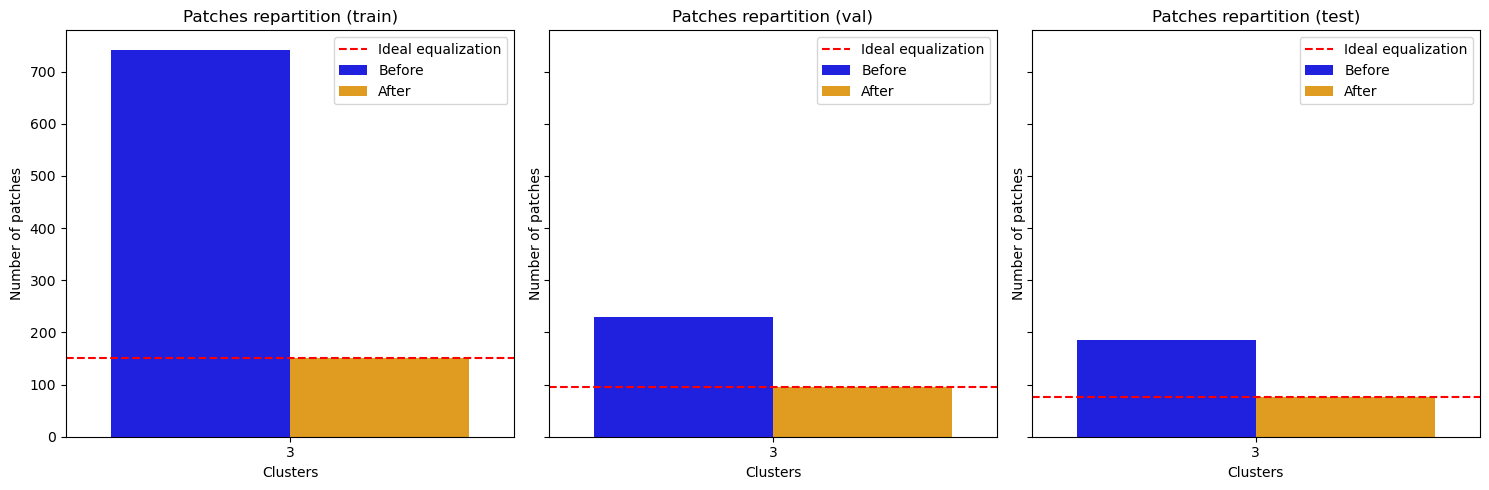

<Figure size 1200x600 with 0 Axes>

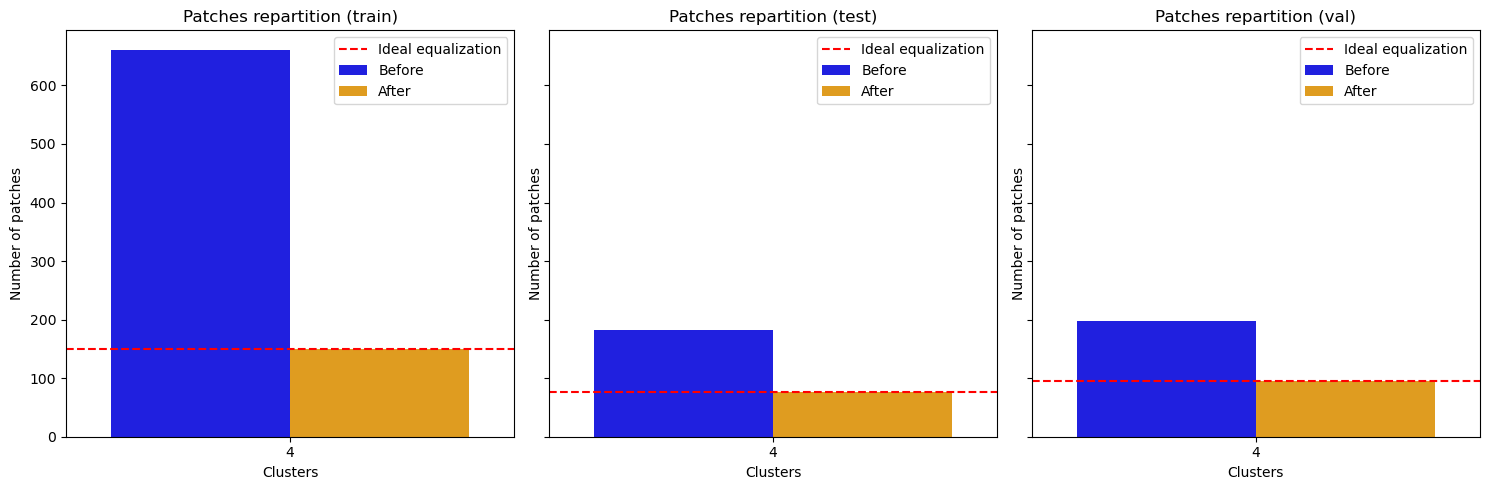

<Figure size 1200x600 with 0 Axes>

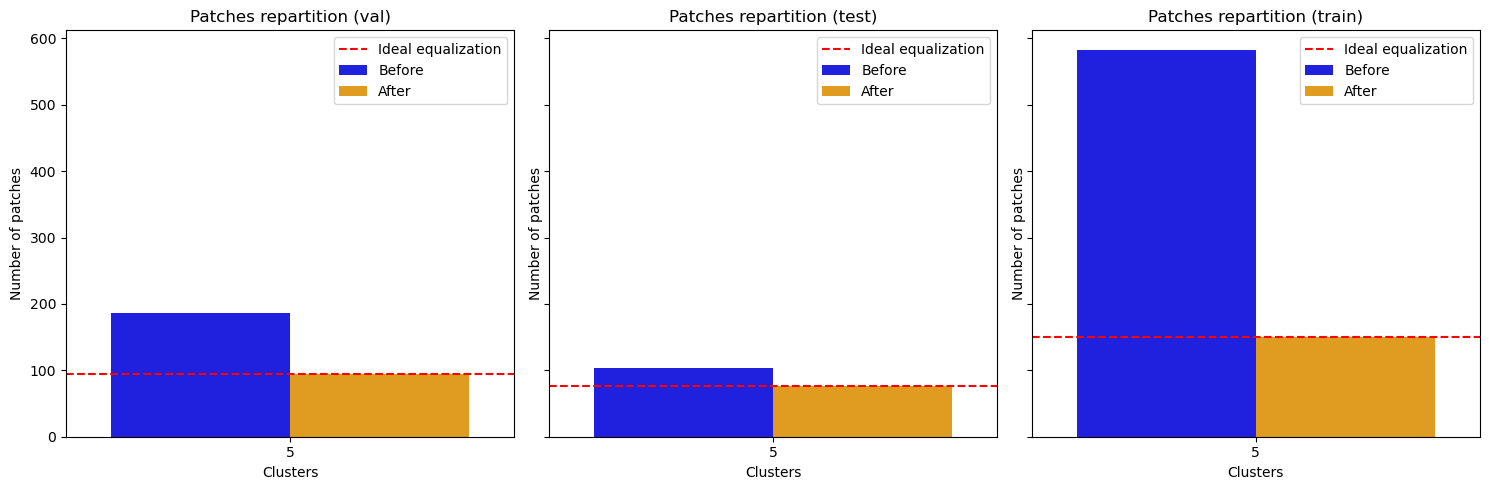

<Figure size 1200x600 with 0 Axes>

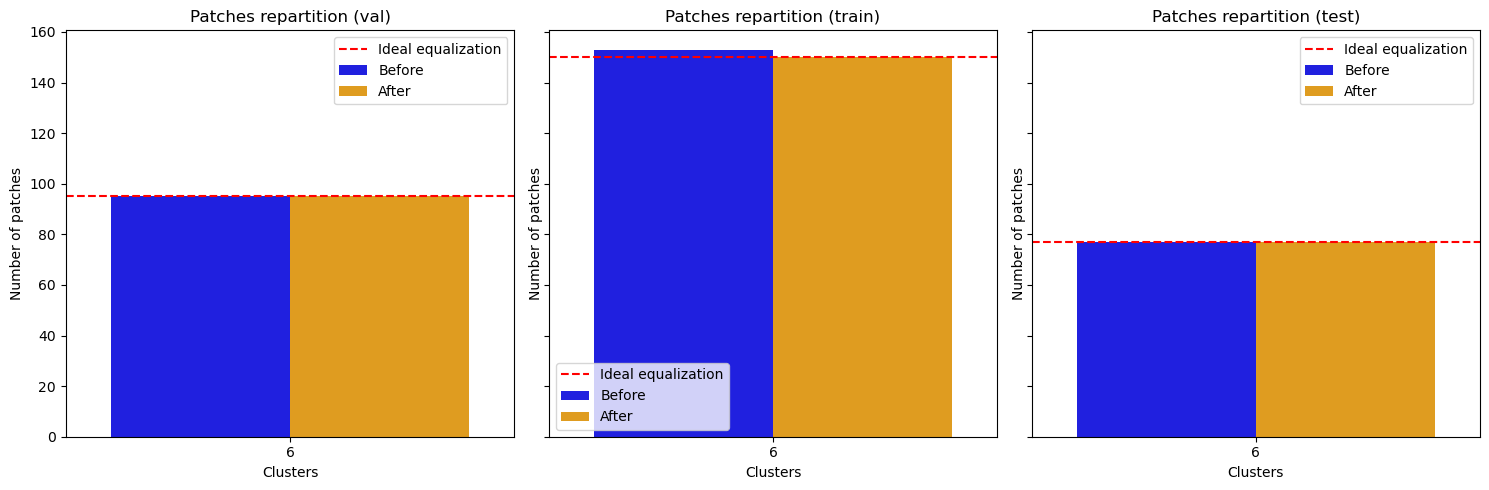

<Figure size 1200x600 with 0 Axes>

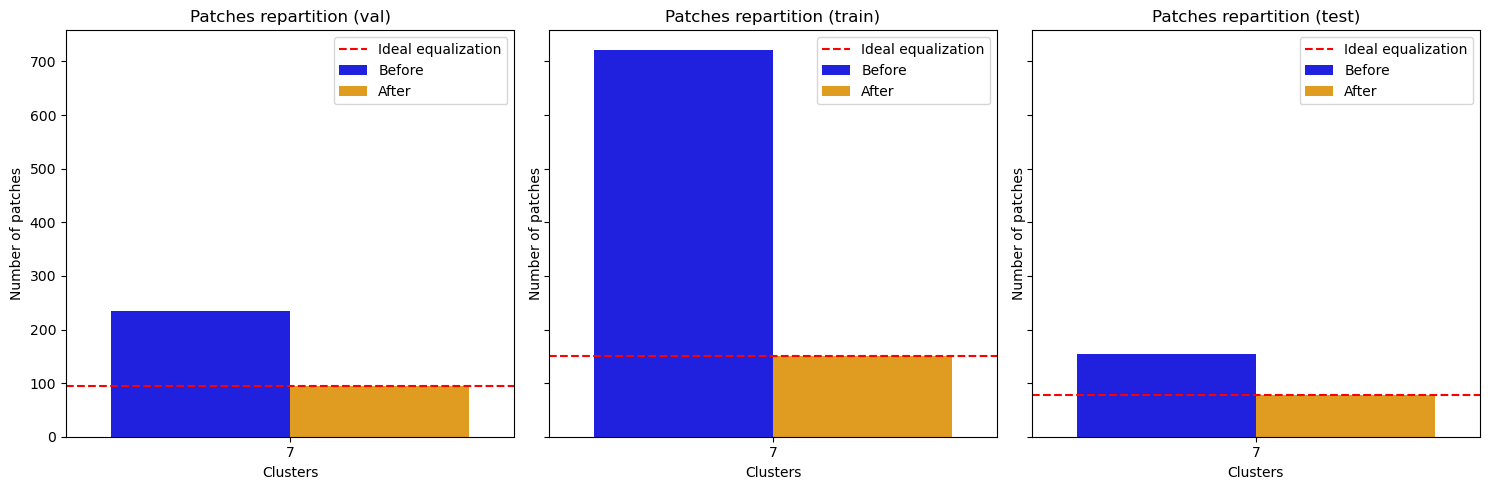

<Figure size 1200x600 with 0 Axes>

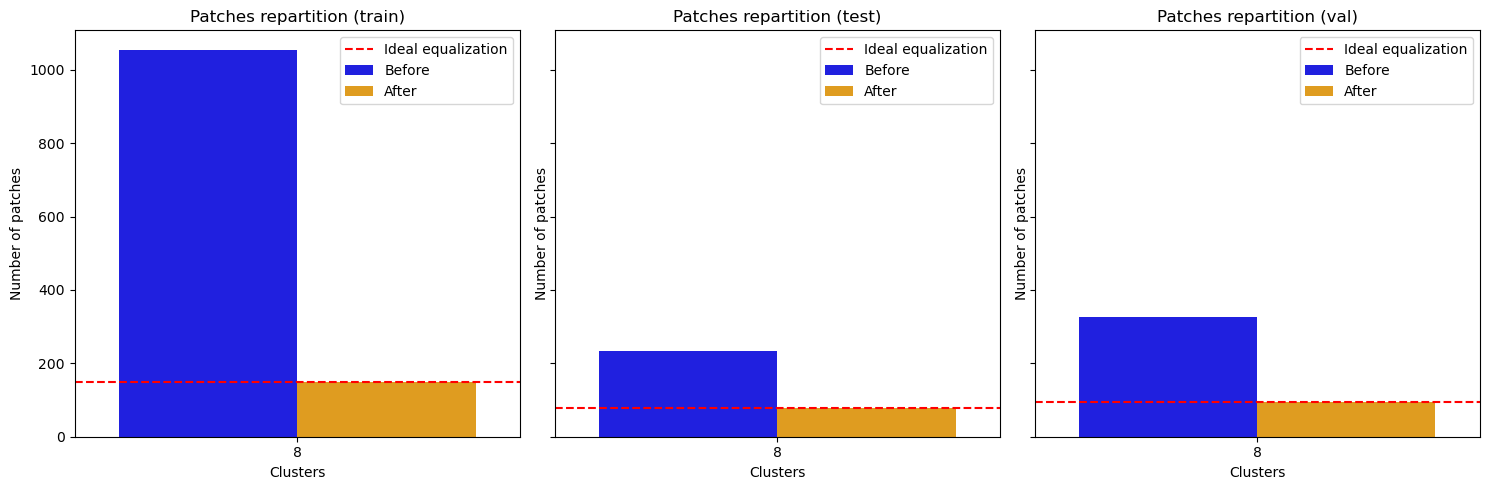

patches_per_image.json saved


In [ ]:
from collections import defaultdict
import matplotlib.pyplot as plt

def redistribute_patches(results, images_reparted, num_shots_train, num_shots_val, num_shots_test, random_opti=''):
    patches_per_image = {}
    clusters_distribution = defaultdict(lambda: {'train': {}, 'val': {}, 'test': {}})
    
    num_shots_dict = {'train': num_shots_train, 'val': num_shots_val, 'test': num_shots_test}
    
    for class_id, clusters in results.items():
        for split in ['train', 'val', 'test']:
            num_shots = num_shots_dict[split]
            total_patches = sum(cluster_info.get(split, 0) for cluster_info in clusters.values())

            cluster_patches = {k: v.get(split, 0) for k, v in clusters.items()}
            clusters_distribution[class_id][split] = cluster_patches.copy()

            if total_patches == 0:
                continue
            
            
            for image_path, image_info in images_reparted.items():
                if image_info['class_id'] == class_id and image_info['split'] == split:
                    patches_per_image[image_path] = {'patches': image_info['patches'], 'split': split, 'cluster':image_info['cluster']}

            while sum(cluster_patches.values()) < num_shots and split == "train":
                min_cluster = min(cluster_patches, key=cluster_patches.get)

                images_with_patches = [
                    img for img, img_info in images_reparted.items()
                    if img_info['class_id'] == class_id and img_info['split'] == split and patches_per_image.get(img, {}).get('patches', 0) > 0
                ]

                if all(patches_per_image[img]['patches'] == 1 for img in images_with_patches):
                    min_image = random.choice(images_with_patches)
                else:
                    min_image = min(
                        (img for img in images_with_patches if images_reparted[img]['cluster'] == min_cluster),
                        key=lambda img: patches_per_image[img]['patches'],
                        default=None
                    )

                if not min_image or patches_per_image[min_image]['patches'] == 0:
                    print(f"Impossible de réduire davantage les patches pour la classe {class_id}, split {split}.")
                    break

            
                patches_per_image[min_image]['patches'] += 1
                cluster_patches[min_cluster] += 1
            
            

            
            while sum(cluster_patches.values()) > num_shots:
            
                max_cluster = max(cluster_patches, key=cluster_patches.get)

                images_with_patches = [
                    img for img, img_info in images_reparted.items()
                    if img_info['class_id'] == class_id and img_info['split'] == split and patches_per_image.get(img, {}).get('patches', 0) > 0
                ]

                if all(patches_per_image[img]['patches'] == 1 for img in images_with_patches):
                    max_image = random.choice(images_with_patches)
                else:
                    max_image = max(
                        (img for img in images_with_patches if images_reparted[img]['cluster'] == max_cluster),
                        key=lambda img: patches_per_image[img]['patches'],
                        default=None
                    )

                if not max_image or patches_per_image[max_image]['patches'] == 0:
                    print(f"Impossible de réduire davantage les patches pour la classe {class_id}, split {split}.")
                    break

            
                patches_per_image[max_image]['patches'] -= 1
                cluster_patches[max_cluster] -= 1

            clusters_distribution[class_id][split] = cluster_patches.copy()
    
    plot_clusters_distribution(clusters_distribution,random_opti)
    plot_before_after_repartition(results, clusters_distribution, num_shots_dict,random_opti)
    # plot_patches_per_image(images_reparted, patches_per_image_before=images,patches_per_image_after=patches_per_image,random_opti=random_opti)
    return patches_per_image

def plot_clusters_distribution(clusters_distribution, random_opti):
    for class_id, splits in clusters_distribution.items():
        fig, axes = plt.subplots(1, 3, figsize=(15, 5))
        
        for ax, (split, clusters) in zip(axes, splits.items()):
            print(sum(clusters.values()))
            if clusters and sum(clusters.values()) > 0:
                ax.bar(clusters.keys(), clusters.values())

            
            ax.set_xlabel("Clusters")
            ax.set_ylabel("Number of attributed patches")
            ax.set_title(f"Patches repartition ({split}) - Class {class_id}")
            ax.set_xticks(list(clusters.keys()))
            ax.set_xticklabels(list(clusters.keys()), rotation=45)
        plt.savefig(f"{random_opti}Repartition_des_patches")
        plt.tight_layout()
        plt.show()

import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

def plot_before_after_repartition(results, clusters_distribution, num_shots_dict, random_opti):
    """
    Show patches repartition before and after equalization
    """
    for class_id, clusters in results.items():
        plt.figure(figsize=(12, 6))
        df = []

        num_clusters = len(clusters)

        for cluster, splits in clusters.items():
            for split, count in splits.items():
                df.append({"Split": split, "Patches": count, "Cluster": cluster, "Status": "Before"})

        for split, splits in clusters_distribution[class_id].items():
            for cluster, count in splits.items():
                df.append({"Split": split, "Patches": count, "Cluster": cluster, "Status": "After"})


        df = pd.DataFrame(df)
        
        df["Split"], df["Cluster"] = df["Split"].astype(str), df["Cluster"].astype(str) 
        splits = df["Split"].unique()

        fig, axes = plt.subplots(1, len(splits), figsize=(15, 5), sharey=True)

        for ax, split in zip(axes, splits):
            num_shots = num_shots_dict[split]
            df_split = df[df["Split"] == split]
            sns.barplot(x="Cluster", y="Patches", hue="Status", data=df_split, ax=ax, palette={"Before": "blue", "After": "orange"})
            
            ax.axhline(num_shots / df_split["Cluster"].nunique(), color="red", linestyle="dashed", label="Ideal equalization")
            
            ax.set_title(f"Patches repartition ({split})")
            ax.set_xlabel("Clusters")
            ax.set_ylabel("Number of patches")
            ax.legend()

        plt.tight_layout()
        plt.savefig(f"{random_opti}repartition_patches_avant_apres_class_{class_id}.pdf")
        plt.show()

def plot_patches_per_image(images_reparted, patches_per_image_before, patches_per_image_after, random_opti):
    df = []
    
    for image_path, image_info in images_reparted.items():
        cluster = image_info.get("cluster")
        split = image_info.get("split")
        
        before = patches_per_image_before.get(image_path, {}).get("patches", 0)
        after = patches_per_image_after.get(image_path, {}).get("patches", 0)
        
        if before > 0:
            df.append({"Image": image_path, "Patches": before, "Cluster": cluster, "Split": split, "Status": "Before"})
            df.append({"Image": image_path, "Patches": after, "Cluster": cluster, "Split": split, "Status": "After"})
    
    df = pd.DataFrame(df)
    
    clusters = sorted(df["Cluster"].unique())
    
    for cluster in clusters:
        df_cluster = df[df["Cluster"] == cluster]
        if df_cluster.empty:
            continue
        
        fig, axes = plt.subplots(1, 3, figsize=(18, 5), sharey=True)
        
        for j, split in enumerate(["train", "val", "test"]):
            ax = axes[j]
            df_cluster_split = df_cluster[df_cluster["Split"] == split]
            
            if not df_cluster_split.empty:
                sns.barplot(x="Image", y="Patches", hue="Status", data=df_cluster_split, ax=ax, palette={"Before": "blue", "After": "orange"})
                ax.set_yscale("log") 
                ax.set_title(f"Cluster {cluster} - {split}")
                ax.set_xlabel("Image Path")
                ax.set_ylabel("Number of patches (log scale)")
                ax.set_xticklabels(ax.get_xticklabels(), rotation=90)
                ax.legend(title="State")
            else:
                ax.set_visible(False)
        
        plt.tight_layout()
        plt.savefig(f"{random_opti}patches_per_image_cluster_{cluster}.pdf")
        plt.show()


random_opti = 'random_'
# random_opti = ''
images_reparted = load_dict(f"{random_opti}image_reparted.json")
results = load_dict(f"{random_opti}results.json")

# Patches Redistribution
patches_per_image = redistribute_patches(results, images_reparted, 150, 95, 77, random_opti)

save_dict(patches_per_image, "patches_per_image.json")


### Creation des 3 folders du dataset concrètement. 

In [ ]:
import os
import random
import shutil
from collections import defaultdict
from PIL import Image, ImageOps

def setup_folders():
    for folder in [f"train_{res}_51_52", f"val_{res}_51_52", f"test_{res}_51_52"]:
        if label_path == "labels_low_res/":
            folder +=  "_low_res" 
        if os.path.exists(folder):
            shutil.rmtree(folder)   
        os.makedirs(folder)

def extract_patches(image_path, patch_size=(224, 224), min_patch_area_ratio=0.6):

    image = Image.open(image_path)
    if round((image.size[0])) %224 != 0 or  round((image.size[1])) %224 != 0:
        print("ATTENTION", round((image.size[0])) %224, round((image.size[1])) %224)
        print(image.size)
    # if image.size[0] < patch_size[0] or image.size[1] < patch_size[1]:
    #     image = ImageOps.pad(image, patch_size, color=(0, 0, 0))
    
    min_patch_area = patch_size[0] * patch_size[1] * min_patch_area_ratio
    patches = []

    
    
    for x in range(0, image.size[0], patch_size[0]):
        for y in range(0, image.size[1], patch_size[1]):
            
            actual_width = min(patch_size[0], image.size[0] - x)
            actual_height = min(patch_size[1], image.size[1] - y)

            actual_height, actual_width = 224, 224
            
            if actual_width * actual_height >= min_patch_area:
                patch = image.crop((x, y, x + actual_width, y + actual_height))
                patches.append(patch)
    
    return patches


def rotate_patch(patch, angle):
    """Effectue une rotation de l'image (patch) selon l'angle spécifié."""
    k = angle // 90  # Convertit l'angle en nombre de rotations de 90°
    return np.rot90(patch, k)

def augment_patches(patches, num_patches):
    selected_patches = patches.copy()
    # Dictionnaire pour garder en mémoire quelles rotations ont été faites par patch
    rotations_done = {i: set() for i in range(len(patches))}

    while len(selected_patches) < num_patches:
        i = random.randint(0, len(patches) - 1)  # On sélectionne un patch au hasard
        available_rotations = {90, 180, 270} - rotations_done[i]

        if not available_rotations:
            continue  # Ce patch a déjà toutes les augmentations possibles

        rot = random.choice(list(available_rotations))
        rotated_patch = rotate_patch(patches[i], rot)
        selected_patches.append(rotated_patch)
        rotations_done[i].add(rot)

    return selected_patches

def save_patches(patches_per_image, patch_size=(224, 224)):
    for image_path, info in patches_per_image.items():
        num_patches = info["patches"]
        split = info["split"] + f"_{res}_51_52"
       
        cluster = info["cluster"]
        
        patches = extract_patches(image_path, patch_size)

        if num_patches > len(patches):
            selected_patches = augment_patches(patches, num_patches)
        else:
            selected_patches = random.sample(patches, min(num_patches, len(patches)))
            
            if label_path == "labels_low_res/":
            
                split +=  "_low_res" 
        for idx, patch in enumerate(selected_patches):
            patch_filename = f"{os.path.basename(image_path).split('.')[0]}_patch{idx}.png"
            patch_path = os.path.join(split, patch_filename)
            try:
                patch.save(patch_path)
            except AttributeError:
                Image.fromarray(patch).save(patch_path)

def main(patches_per_image):
    setup_folders()
    save_patches(patches_per_image)
    print("Patches generation over")


main(load_dict("patches_per_image.json"))




Patches generation over


### Nous avons donc construit un dataset de patches pour un niveau de résolution donné qui nous servira ensuite à alimenter notre code de finetuning de modèles de vision